### 주제: 건설 장비 내부 기계 부품의 마모 상태 및 윤활 성능을 오일 데이터 분석을 통해 확인하고, AI를 활용한 분류 모델 개발을 통해 적절한 교체 주기를 파악

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import pickle

from sklearn.preprocessing import StandardScaler
from scipy.stats import kurtosis, skew, ttest_ind, mannwhitneyu
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.feature_selection import RFECV


데이터 분석 목표: 샘플 오일 관련 부품 정보를 분석해 오일 정상 여부 예측

In [2]:
train = pd.read_csv('D:/김동영/11_Github/mygit-1/데이터사이언스수업/과제/최종과제/HD현대해커톤/train.csv')
test_df = pd.read_csv('D:/김동영/11_Github/mygit-1/데이터사이언스수업/과제/최종과제/HD현대해커톤/test.csv')
submission = pd.read_csv('D:/김동영/11_Github/mygit-1/데이터사이언스수업/과제/최종과제/HD현대해커톤/sample_submission.csv')

In [3]:
test_df.columns

Index(['ID', 'COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR', 'ANONYMOUS_2', 'AG',
       'CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V',
       'V40', 'ZN'],
      dtype='object')

In [4]:
columns = ['ID', 'COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR', 'ANONYMOUS_2', 'AG',
       'CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V',
       'V40', 'ZN','Y_LABEL']

변수 정보   
ANONYMOUS_1 - 무명 Feature 1. 수치형 데이터   
ANONYMOUS_2 - 무명 Feature 2. 수치형 데이터   
AG, CO, CR, FE, H2O, MN, MO, NI, TI, V, ZN - 원소기호   
V40 - 40도에서 측정한 액체의 점도   
YEAR - 오일샘플 및 진단 해(Year)    
PQINDEX(Particle Quantifier Index) : Particle Quantifier Index(PQ Index), 또는 PQI라고도 불리는 이 지표는 입자의 크기와 상관없이 윤활유 샘플 내에 존재하는 전체 강자성 물질(자성을 띤 금속 입자)의 양을 측정하는 방법이다.
이 지표는 마모로 인한 문제가 발생할 가능성을 조기에 감지하기 위한 선별 검사 도구로 사용되며, 예지 보전(predictive maintenance) 프로그램에서 자주 활용된다.    

Y_LABEL - 타깃변수로 0일 때 정상, 1일 때 비정상


train 데이터에는 존재하나 test 데이터에는 없는 변수들 존재했었다. 이는 모델 학습 시 사용할 수 없는 변수들이기 때문에 제거해주었다.    

In [5]:
train_df = train[columns]

In [6]:
train_df['COMPONENT_ARBITRARY'].value_counts()

COMPONENT_ARBITRARY
COMPONENT3    7050
COMPONENT1    3890
COMPONENT2    2316
COMPONENT4     839
Name: count, dtype: int64

부품 종류로는 4개가 있으며 1은 3890개, 2는 2316개, 3은 7050개, 4는 839개씩 있다.    

In [7]:
# COMPONENT_ARBITRARY별 Y_LABEL의 0,1 개수
count = train_df.groupby('COMPONENT_ARBITRARY')['Y_LABEL'].value_counts().unstack().fillna(0)
print("개수:\n", count)

# COMPONENT_ARBITRARY별 Y_LABEL의 0,1 비율
ratio = train_df.groupby('COMPONENT_ARBITRARY')['Y_LABEL'].value_counts(normalize=True).unstack().fillna(0)
print("\n비율:\n", ratio)


개수:
 Y_LABEL                 0     1
COMPONENT_ARBITRARY            
COMPONENT1           3500   390
COMPONENT2           1915   401
COMPONENT3           4906  2144
COMPONENT4            750    89

비율:
 Y_LABEL                     0         1
COMPONENT_ARBITRARY                    
COMPONENT1           0.899743  0.100257
COMPONENT2           0.826857  0.173143
COMPONENT3           0.695887  0.304113
COMPONENT4           0.893921  0.106079


COMPONENT_ARBITRARY별로 오일 정상, 비정상 개수 및 비율을 확인해본 결과 COMPONENT 2와 3에서 이상 오일 비율이 높게 나온 것을 확인할 수 있었다.    
이상 샘플이 Component 3에서 차지하는 비율이 0.3으로 다른 Component에 비해 높게 나온 것을 확인

In [8]:
# YEAR별 Y_LABEL의 0,1 개수
count = train_df.groupby('YEAR')['Y_LABEL'].value_counts().unstack().fillna(0)
print("개수:\n", count)

# YEAR별 Y_LABEL의 0,1 비율
ratio = train_df.groupby('YEAR')['Y_LABEL'].value_counts(normalize=True).unstack().fillna(0)
print("\n비율:\n", ratio)

개수:
 Y_LABEL     0    1
YEAR              
2007      236   92
2008     1062  357
2009      681  268
2010      639  227
2011      910  236
2012      849  224
2013      949  240
2014     1133  267
2015      935  221
2016      771  171
2017      740  156
2018      699  179
2019      520  129
2020      275   98
2021      381   96
2022      291   63

비율:
 Y_LABEL         0         1
YEAR                       
2007     0.719512  0.280488
2008     0.748414  0.251586
2009     0.717597  0.282403
2010     0.737875  0.262125
2011     0.794066  0.205934
2012     0.791240  0.208760
2013     0.798150  0.201850
2014     0.809286  0.190714
2015     0.808824  0.191176
2016     0.818471  0.181529
2017     0.825893  0.174107
2018     0.796128  0.203872
2019     0.801233  0.198767
2020     0.737265  0.262735
2021     0.798742  0.201258
2022     0.822034  0.177966


YEAR별로 오일 정상, 비정상 개수 및 비율을 확인해본 결과 특정 연도에서 비정상 비율이 높게 나온 것을 확인할 수 있었다

In [9]:
train_df.groupby('COMPONENT_ARBITRARY').mean(numeric_only=True)

# 평균값을 표로 보기 좋게 출력
mean_df = train_df.groupby('COMPONENT_ARBITRARY').mean(numeric_only=True)
display(mean_df)

,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN,Y_LABEL
COMPONENT_ARBITRARY,,,,,,,,,,,,,,,,,,
COMPONENT1,-0.986054,2013.729563,-0.959173,0.025193,0.014396,1.910540,9.929563,27.057069,0.002699,0.514910,69.364267,0.152185,20.422622,0.055013,0.024422,102.678103,1161.010283,0.100257
COMPONENT2,-0.986206,2013.718912,-0.961256,0.024180,0.009499,0.515976,56.677029,18.890328,0.003282,0.155872,0.652418,0.027634,27.230570,0.032815,0.010794,52.720695,505.785838,0.173143
COMPONENT3,-0.984818,2013.494043,-0.961531,0.028227,0.044397,5.361986,32.252057,332.500426,0.064525,5.137163,3.415745,1.362553,807.300567,1.372908,0.082837,136.411370,241.379574,0.304113
COMPONENT4,-0.984588,2014.443385,-0.953130,0.013111,0.007151,0.091776,107.109654,21.651967,0.001549,0.852205,50.958284,0.034565,21.091776,0.010727,0.011919,69.310012,1081.669845,0.106079


ANONYMOUS_1 과 ANONYMOUS_2는 더해서 하나의 변수로 만들어주었다.

In [10]:
# ANONYMOUS_1 과 ANONYMOUS_2 더해서 새로운 피처 생성
train_df['ANONYMOUS_SUM'] = train_df['ANONYMOUS_1'] + train_df['ANONYMOUS_2']

# ANONYMOUS_1, ANONYMOUS_2 제거
train_df = train_df.drop(columns=['ANONYMOUS_1', 'ANONYMOUS_2'])

C:\Users\KimDongyoung\AppData\Local\Temp\ipykernel_23512\1612360360.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['ANONYMOUS_SUM'] = train_df['ANONYMOUS_1'] + train_df['ANONYMOUS_2']


In [11]:
# Component와 YEAR로 그룹화하여 각 변수의 평균값을 확인
grouped_stats = train_df.groupby(['COMPONENT_ARBITRARY', 'YEAR', 'Y_LABEL']).median(numeric_only=True)
grouped_stats

AG   CO   CR    CU    FE  H2O   MN     MO  \
COMPONENT_ARBITRARY YEAR Y_LABEL                                               
COMPONENT1          2007 0        0.0  0.0  2.0   3.0  23.5  0.0  1.0   21.0   
                         1        0.0  0.0  3.0  22.0  47.0  0.0  1.0  104.0   
                    2008 0        0.0  0.0  1.0   4.0  21.0  0.0  1.0   37.0   
                         1        0.0  0.0  4.0   9.0  51.5  0.0  1.0   99.0   
                    2009 0        0.0  0.0  2.0   4.0  24.0  0.0  1.0   37.0   
...                               ...  ...  ...   ...   ...  ...  ...    ...   
COMPONENT4          2020 1        0.0  0.0  0.0  17.5  44.0  0.0  1.5   22.0   
                    2021 0        0.0  0.0  0.0   0.0  11.0  0.0  0.0    2.0   
                         1        0.0  0.0  0.0   5.5  54.5  0.0  0.0    5.5   
                    2022 0        0.0  0.0  0.0   1.0  11.0  0.0  0.0   20.0   
                         1        0.0  0.0  0.0   1.0  11.0  0.0  0.0   25.0   

                                   NI  PQINDEX   TI    V     V40      ZN  \
COMPONENT_ARBITRARY YEAR Y_LABEL                                           
COMPONENT1          2007 0        0.0     17.0  0.0  0.0  101.30  1208.5   
                         1        0.0     18.0  0.0  0.0  112.60  1280.0   
                    2008 0        0.0     14.0  0.0  0.0  105.30  1225.0   
                         1        1.0     17.0  0.0  0.0  109.25  1278.0   
                    2009 0        0.0     12.0  0.0  0.0  103.20  1183.0   
...                               ...      ...  ...  ...     ...     ...   
COMPONENT4          2020 1        0.0     48.0  0.0  0.0   53.35   480.5   
                    2021 0        0.0     11.0  0.0  0.0   71.40  1038.0   
                         1        0.0     25.0  0.0  0.0   64.00  1109.0   
                    2022 0        0.0      8.0  0.0  0.0   70.40  1077.0   
                         1        0.0     10.0  0.0  0.0   59.80  1162.0   

                                  ANONYMOUS_SUM  
COMPONENT_ARBITRARY YEAR Y_LABEL                 
COMPONENT1          2007 0            -1.953617  
                         1            -1.960353  
                    2008 0            -1.958369  
                         1            -1.928166  
                    2009 0            -1.988598  
...                                         ...  
COMPONENT4          2020 1            -1.958085  
                    2021 0            -1.904710  
                         1            -1.977001  
                    2022 0            -1.912576  
                         1            -1.894914  

[127 rows x 15 columns]

In [12]:
# Component와 YEAR로 그룹화하여 각 변수의 평균값을 확인
grouped_stats2 = train_df.groupby(['COMPONENT_ARBITRARY','Y_LABEL']).mean(numeric_only=True)
grouped_stats2

YEAR        AG        CO         CR  \
COMPONENT_ARBITRARY Y_LABEL                                               
COMPONENT1          0        2013.795429  0.023143  0.014571   1.378000   
                    1        2013.138462  0.043590  0.012821   6.689744   
COMPONENT2          0        2013.817755  0.025587  0.007833   0.401044   
                    1        2013.246883  0.017456  0.017456   1.064838   
COMPONENT3          0        2013.614757  0.024868  0.023848   1.779250   
                    1        2013.217817  0.035914  0.091418  13.560168   
COMPONENT4          0        2014.441333  0.013333  0.004000   0.076000   
                    1        2014.460674  0.011236  0.033708   0.224719   

                                     CU          FE       H2O         MN  \
COMPONENT_ARBITRARY Y_LABEL                                                
COMPONENT1          0          8.921714   22.762571  0.001571   0.450571   
                    1         18.974359   65.597436  0.012821   1.092308   
COMPONENT2          0         52.925849   13.013055  0.001097   0.096606   
                    1         74.591022   46.957606  0.013716   0.438903   
COMPONENT3          0         19.878516  156.025275  0.004260   2.804525   
                    1         60.565765  736.319030  0.202425  10.474813   
COMPONENT4          0        107.133333   19.585333  0.001200   0.644000   
                    1        106.910112   39.067416  0.004494   2.606742   

                                    MO        NI      PQINDEX        TI  \
COMPONENT_ARBITRARY Y_LABEL                                               
COMPONENT1          0        69.089429  0.102286    12.703143  0.020571   
                    1        71.830769  0.600000    89.700000  0.364103   
COMPONENT2          0         0.572324  0.023499    13.025065  0.021932   
                    1         1.034913  0.047382    95.069825  0.084788   
COMPONENT3          0         2.704240  0.622503   316.359967  0.135956   
                    1         5.043843  3.055970  1930.693563  4.203358   
COMPONENT4          0        52.713333  0.034667    16.044000  0.009333   
                    1        36.168539  0.033708    63.629213  0.022472   

                                    V         V40           ZN  ANONYMOUS_SUM  
COMPONENT_ARBITRARY Y_LABEL                                                    
COMPONENT1          0        0.021429  102.497291  1160.656571      -1.945416  
                    1        0.051282  104.300769  1164.184615      -1.943537  
COMPONENT2          0        0.012533   52.290501   518.969191      -1.946706  
                    1        0.002494   54.775112   442.827930      -1.951072  
COMPONENT3          0        0.023848  134.057440   260.599674      -1.946695  
                    1        0.217817  141.797743   197.399254      -1.945556  
COMPONENT4          0        0.013333   69.785867  1096.238667      -1.938453  
                    1        0.000000   65.300000   958.898876      -1.931529

In [13]:
# Component와 YEAR로 그룹화하여 각 변수의 평균값을 확인
grouped_stats3 = train_df.groupby(['COMPONENT_ARBITRARY','Y_LABEL']).median(numeric_only=True)
grouped_stats3

YEAR   AG   CO   CR    CU     FE  H2O   MN  \
COMPONENT_ARBITRARY Y_LABEL                                                 
COMPONENT1          0        2014.0  0.0  0.0  1.0   3.0   18.0  0.0  0.0   
                    1        2013.0  0.0  0.0  3.0   7.0   43.5  0.0  1.0   
COMPONENT2          0        2014.0  0.0  0.0  0.0  11.0    5.0  0.0  0.0   
                    1        2013.0  0.0  0.0  0.0  21.0   14.0  0.0  0.0   
COMPONENT3          0        2014.0  0.0  0.0  1.0   4.0   96.0  0.0  1.0   
                    1        2013.0  0.0  0.0  4.0   5.0  379.0  0.0  5.0   
COMPONENT4          0        2014.0  0.0  0.0  0.0   5.0   16.0  0.0  0.0   
                    1        2014.0  0.0  0.0  0.0  21.0   23.0  0.0  0.0   

                               MO   NI  PQINDEX   TI    V     V40      ZN  \
COMPONENT_ARBITRARY Y_LABEL                                                 
COMPONENT1          0        20.0  0.0     11.0  0.0  0.0  100.50  1148.0   
                    1        34.0  0.0     17.0  0.0  0.0  102.95  1170.5   
COMPONENT2          0         0.0  0.0     11.0  0.0  0.0   47.10   566.0   
                    1         0.0  0.0     30.0  0.0  0.0   53.00   445.0   
COMPONENT3          0         0.0  0.0    106.0  0.0  0.0  136.50    38.0   
                    1         1.0  1.0    744.0  0.0  0.0  138.40    38.0   
COMPONENT4          0        10.5  0.0     15.0  0.0  0.0   70.65  1131.0   
                    1         8.0  0.0     25.0  0.0  0.0   68.20  1107.0   

                             ANONYMOUS_SUM  
COMPONENT_ARBITRARY Y_LABEL                 
COMPONENT1          0            -1.979308  
                    1            -1.978154  
COMPONENT2          0            -1.978818  
                    1            -1.982075  
COMPONENT3          0            -1.976357  
                    1            -1.975860  
COMPONENT4          0            -1.977908  
                    1            -1.972581

변수들간의 수치를 직접 비교하기 위해서 스케일링을 적용시켰다

In [14]:
# 스케일링 대상 수치형 변수 리스트 (ID, COMPONENT_ARBITRARY, Y_LABEL 제외)
num_cols = [col for col in train_df.columns if col not in ['ID', 'COMPONENT_ARBITRARY', 'Y_LABEL', 'YEAR']]

scaler = StandardScaler()
train_df_scaled = train_df.copy()
train_df_scaled[num_cols] = scaler.fit_transform(train_df[num_cols])

display(train_df_scaled.head())

,ID,COMPONENT_ARBITRARY,YEAR,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN,Y_LABEL,ANONYMOUS_SUM
0,TRAIN_00000,COMPONENT3,2011,-0.150214,-0.089633,0.339245,0.336858,1.331290,-0.041588,1.186914,-0.384284,1.384414,5.293270,0.622282,-0.10655,0.899892,-0.966002,1,-0.418234
1,TRAIN_00001,COMPONENT2,2021,-0.150214,-0.089633,-0.115388,-0.027612,-0.330406,-0.041588,-0.250456,-0.400998,-0.191804,-0.259244,-0.102635,-0.10655,-1.317376,0.119147,0,-0.121986
2,TRAIN_00002,COMPONENT2,2015,-0.150214,-0.089633,-0.080416,-0.252497,-0.326655,-0.041588,-0.250456,-0.400998,-0.191804,-0.260552,-0.102635,-0.10655,-0.740886,-0.332215,0,-0.366290
3,TRAIN_00003,COMPONENT3,2010,-0.150214,-0.089633,-0.115388,-0.260252,-0.264764,-0.041588,-0.160621,-0.400998,-0.191804,-0.242884,-0.102635,-0.10655,0.482642,-1.093888,0,-0.088173
4,TRAIN_00004,COMPONENT3,2015,-0.150214,-0.089633,-0.115388,-0.268007,-0.200996,-0.041588,-0.250456,-0.400998,-0.191804,-0.129674,-0.102635,-0.10655,0.478611,-0.866326,0,-0.280238


## Optuna 튜닝용 모델 학습 함수

In [15]:
# Optuna 튜닝용 objective 함수 예시 (각 모델별)

# random forest
def rf_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'random_state': 42,
        'n_jobs': -1
    }
    model = RandomForestClassifier(**params)
    score = cross_val_score(model, X_train, y_train, scoring='f1', cv=5, n_jobs=-1)
    return score.mean()

# gradient boosting
def gb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'random_state': 42
    }
    model = GradientBoostingClassifier(**params)
    score = cross_val_score(model, X_train, y_train, scoring='f1', cv=5, n_jobs=-1)
    return score.mean()

# lightgbm
def lgbm_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42,
        'n_jobs': -1
    }
    model = LGBMClassifier(**params)
    score = cross_val_score(model, X_train, y_train, scoring='f1', cv=5, n_jobs=-1)
    return score.mean()

# extra trees
def extratrees_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'random_state': 42,
        'n_jobs': -1
    }
    model = ExtraTreesClassifier(**params)
    score = cross_val_score(model, X_train, y_train, scoring='f1', cv=5, n_jobs=-1)
    return score.mean()

# catboost
def catboost_objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500, step=50),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'random_state': 42,
        'verbose': 0
    }
    model = CatBoostClassifier(**params)
    score = cross_val_score(model, X_train, y_train, scoring='f1', cv=5, n_jobs=-1)
    return score.mean()


# adaboost
def adaboost_objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=25),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
            'random_state': 42
        }
        model = AdaBoostClassifier(**params)
        score = cross_val_score(model, X_train, y_train, scoring='f1', cv=5, n_jobs=-1)
        return score.mean()   
    
# xgboost
def xgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'random_state': 42,
        'n_jobs': -1,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }
    model = XGBClassifier(**params)
    score = cross_val_score(model, X_train, y_train, scoring='f1', cv=5, n_jobs=-1)
    return score.mean()

## Component 3

Component 3에서 이상 샘플과 정상 샘플의 수치를 비교해보았을 때 ANONYMOUS_1, ANONYMOUS_2, YEAR, AG 변수를 제외한 나머지 변수들에서 수치적으로 큰 차이를 보였다.    

In [16]:
# COMPONENT3만 추출
comp3_df = train_df_scaled[train_df_scaled['COMPONENT_ARBITRARY'] == 'COMPONENT3']

# Y_LABEL이 0과 1인 데이터 각각 추출
comp3_0 = comp3_df[comp3_df['Y_LABEL'] == 0]
comp3_1 = comp3_df[comp3_df['Y_LABEL'] == 1]

# 주요 변수별 평균 비교
mean_0 = comp3_0.mean(numeric_only=True)
mean_1 = comp3_1.mean(numeric_only=True)
diff = pd.DataFrame({'Y_LABEL=0': mean_0, 'Y_LABEL=1': mean_1})

display(diff)

# 주요 변수별 중앙값 비교
median_0 = comp3_0.median(numeric_only=True)
median_1 = comp3_1.median(numeric_only=True)
median_diff = pd.DataFrame({'Y_LABEL=0': median_0, 'Y_LABEL=1': median_1})

display(median_diff)

,Y_LABEL=0,Y_LABEL=1
YEAR,2013.614757,2013.217817
AG,-0.005568,0.058687
CO,-0.013740,0.201287
CR,-0.053165,0.358835
CU,-0.113855,0.201662
FE,-0.041531,1.046812
H2O,-0.036323,0.208588
MN,0.001490,0.690555
MO,-0.355800,-0.316697
NI,-0.028271,0.611008


,Y_LABEL=0,Y_LABEL=1
YEAR,2014.000000,2013.000000
AG,-0.150214,-0.150214
CO,-0.089633,-0.089633
CR,-0.080416,0.024499
CU,-0.236988,-0.229233
FE,-0.154109,0.376659
H2O,-0.041588,-0.041588
MN,-0.160621,0.198722
MO,-0.400998,-0.384284
NI,-0.191804,0.070899


각 변수에서의 정규분포    
파란색: 정상    
빨간색: 비정상

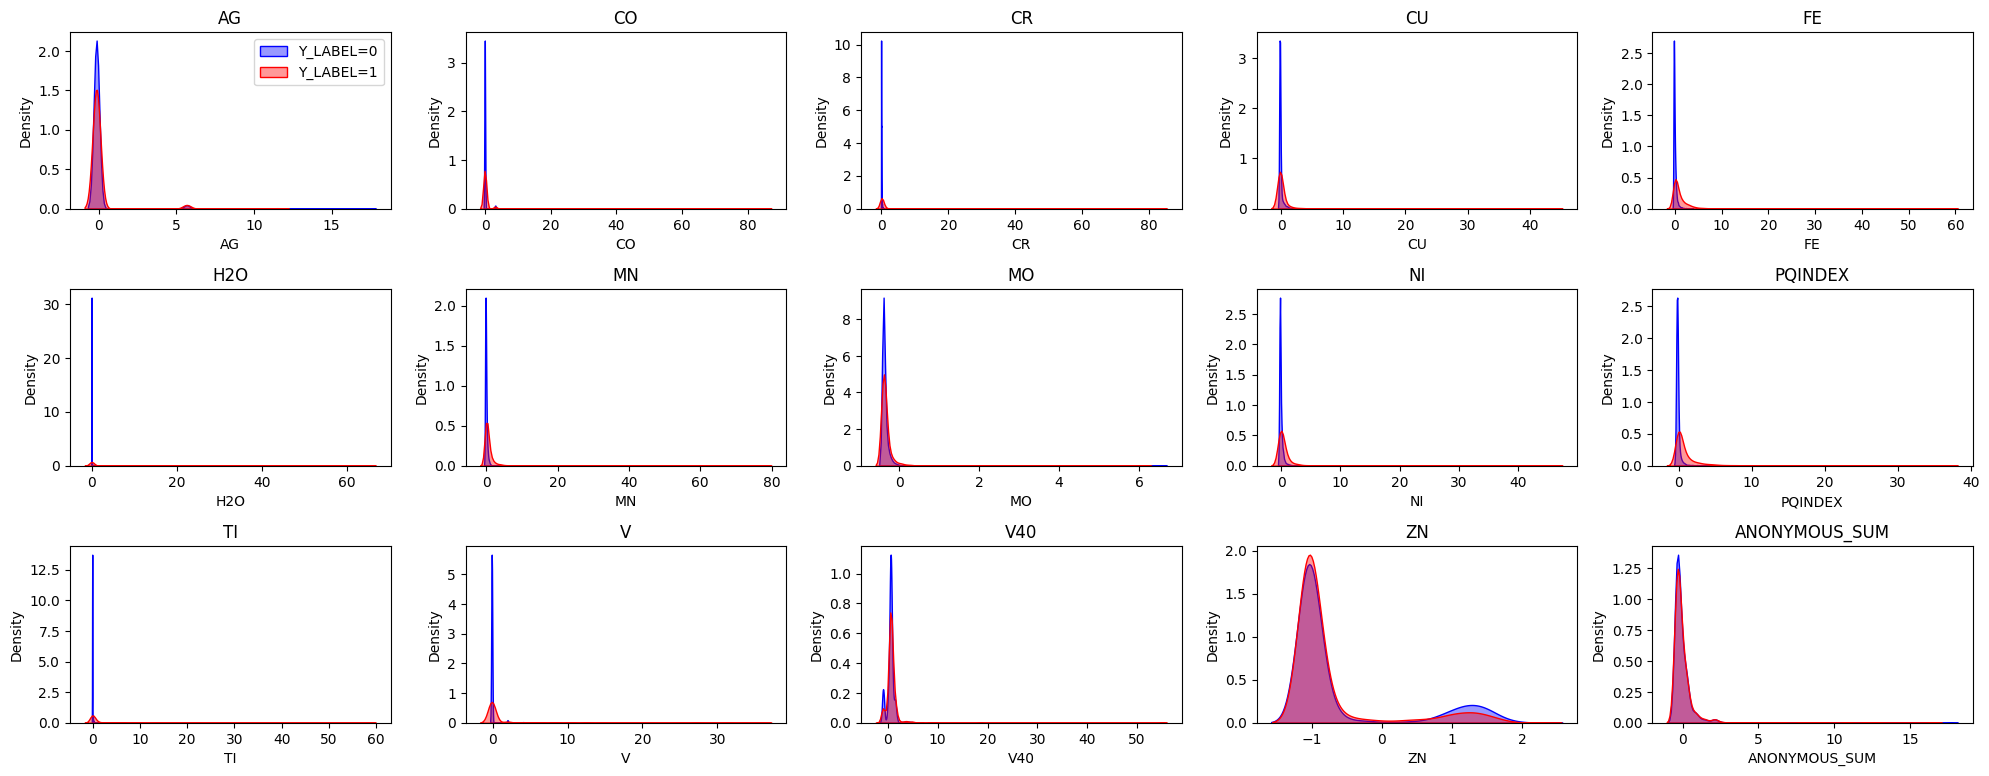

In [17]:
plt.figure(figsize=(20, 10))
for var in num_cols:
  plt.subplot(4, 5, num_cols.index(var)+1)
  sns.kdeplot(comp3_0[var], label='Y_LABEL=0', color='blue', fill=True, alpha=0.4)
  sns.kdeplot(comp3_1[var], label='Y_LABEL=1', color='red', fill=True, alpha=0.4)
  plt.title(var)
  plt.xlabel(var)
  plt.ylabel('Density')
  if num_cols.index(var) == 0:
    plt.legend()
plt.tight_layout()
plt.show()

In [18]:
# 주요 변수별 첨도(kurtosis)와 왜도(skewness) 계산
# independent_vars 정의 (Y_LABEL, ID, COMPONENT_ARBITRARY 제외)
independent_vars = [col for col in comp3_df.columns if col not in ['ID', 'COMPONENT_ARBITRARY', 'Y_LABEL']]

kurt_skew = []
for col in independent_vars:
  kurt_0 = kurtosis(comp3_0[col], nan_policy='omit')
  skew_0 = skew(comp3_0[col], nan_policy='omit')
  kurt_1 = kurtosis(comp3_1[col], nan_policy='omit')
  skew_1 = skew(comp3_1[col], nan_policy='omit')
  kurt_skew.append({
    '변수': col,
    'Y_LABEL=0_첨도': kurt_0,
    'Y_LABEL=0_왜도': skew_0,
    'Y_LABEL=1_첨도': kurt_1,
    'Y_LABEL=1_왜도': skew_1
  })

kurt_skew_df = pd.DataFrame(kurt_skew)
display(kurt_skew_df)

,변수,Y_LABEL=0_첨도,Y_LABEL=0_왜도,Y_LABEL=1_첨도,Y_LABEL=1_왜도
0,YEAR,-0.836721,0.207422,-0.896504,0.360746
1,AG,71.716362,7.829656,40.676281,6.111498
2,CO,415.260376,15.681666,1087.743986,29.016374
3,CR,14.239118,2.968100,620.155557,21.926679
4,CU,191.799066,10.869007,227.042089,13.423523
5,FE,23.742994,4.019570,232.819537,10.692425
6,H2O,955.484288,25.691983,416.393428,19.066077
7,MN,104.042667,8.713548,679.535894,21.096072
8,MO,579.396756,19.157921,164.281723,10.550900
9,NI,272.756374,13.224041,138.962798,9.821042


대부분 변수에서 분포가 비정규적이고, 이상치가 많거나 한쪽으로 치우쳐 있다. 따라서 중앙값이나, 비모수 검정 등으로 비교하는 것이 적합하다.    
특히, 비정상 집단에서 첨도와 왜도가 더 커진다.    

중앙값과 정규분포에선 FE, MN, NI, PQINDEX, CR 이 5가지 변수에서 0과 1의 차이가 도드라지는 것을 알 수 있었다.    

Boxplot으로 시각화하여 분포를 확인해보았다    

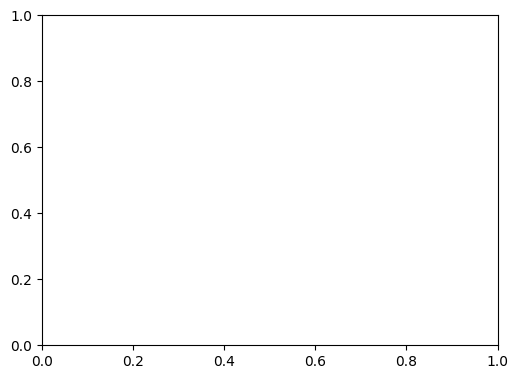

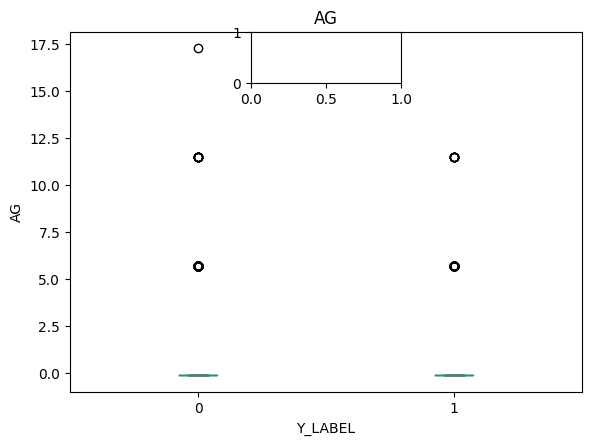

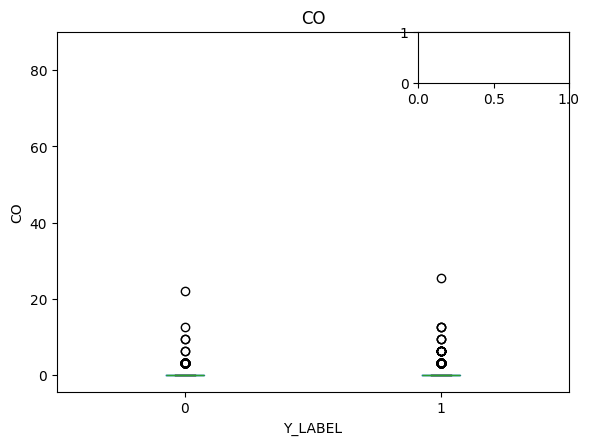

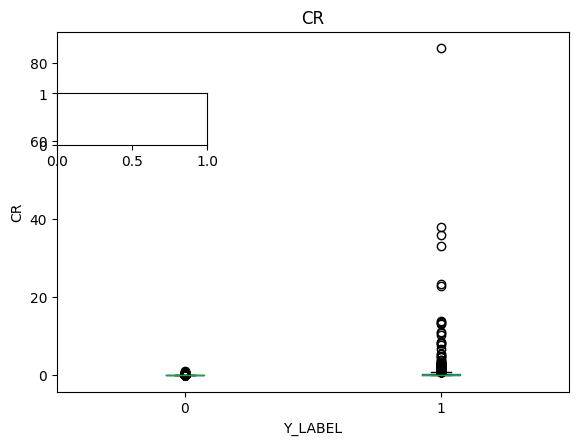

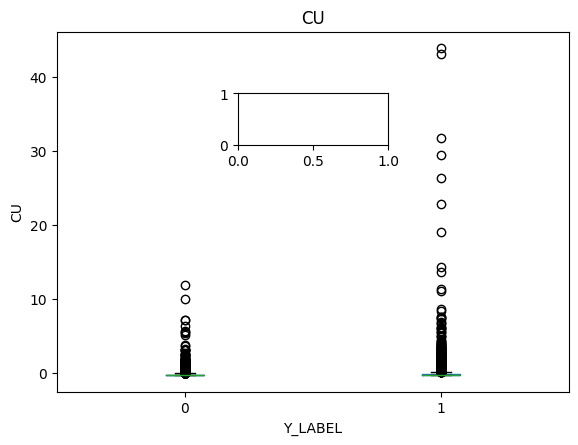

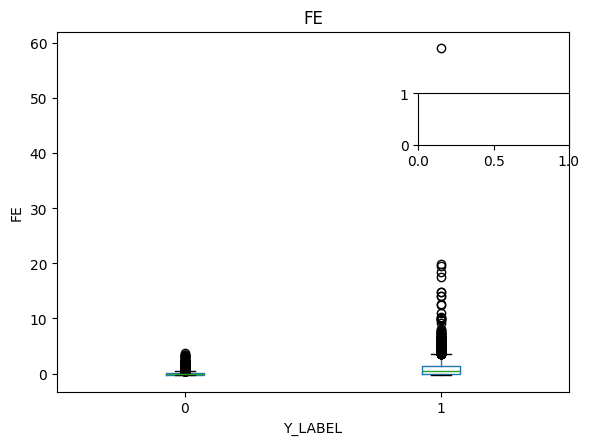

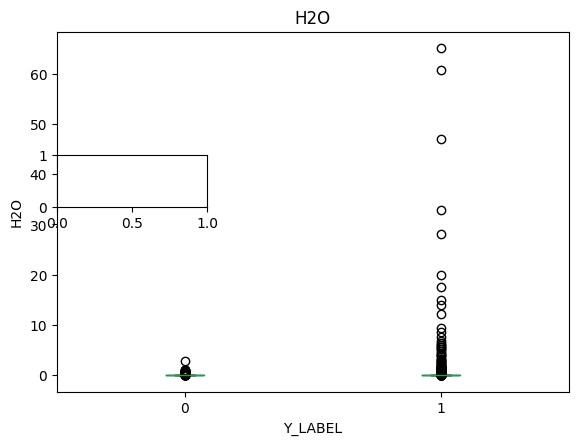

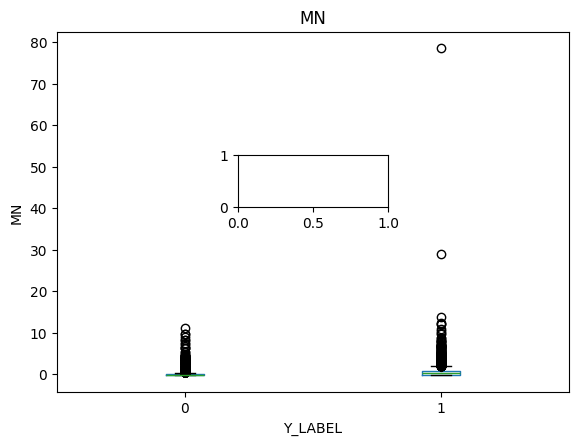

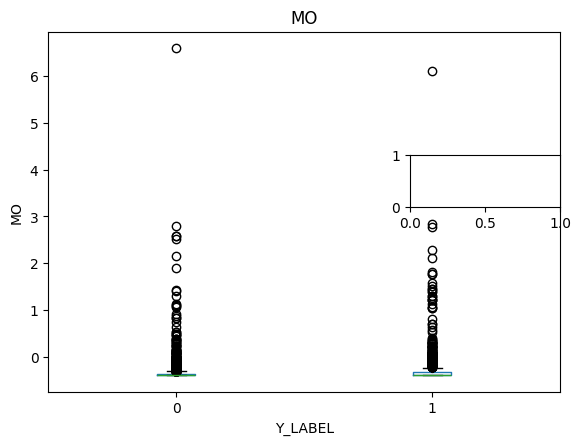

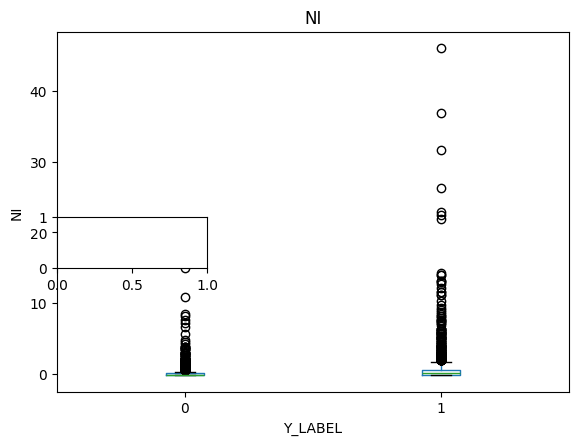

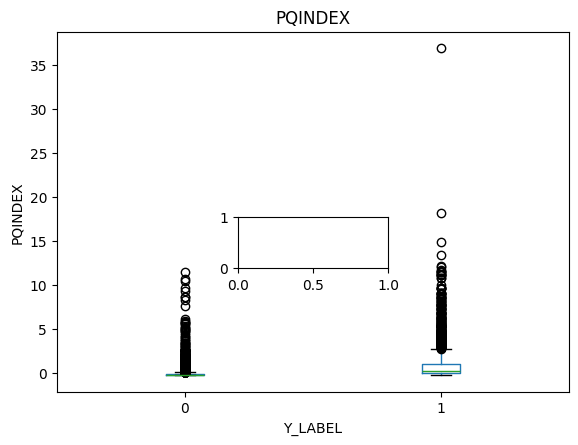

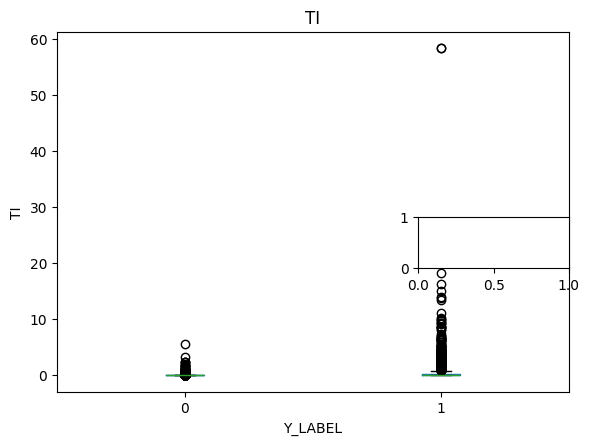

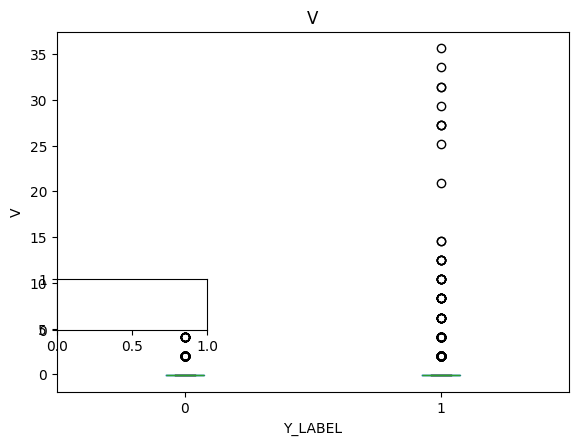

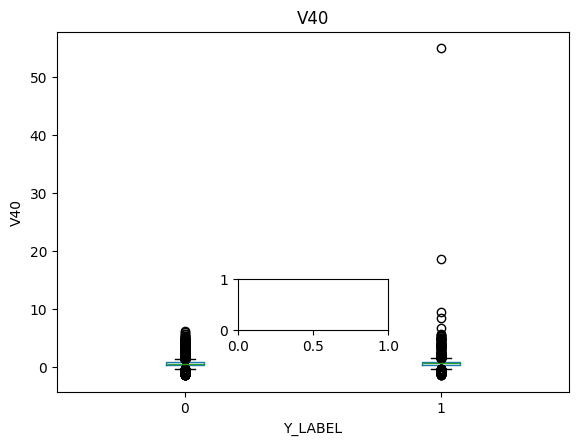

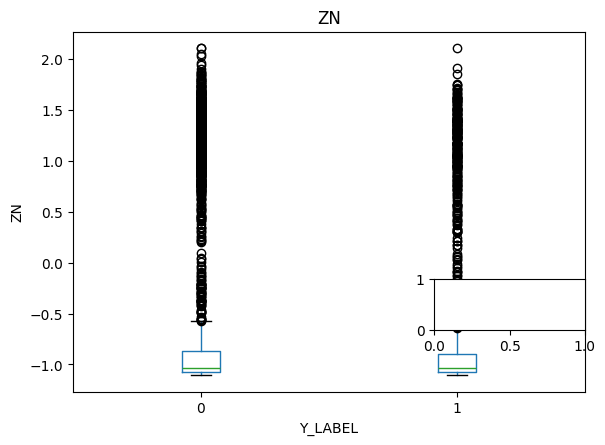

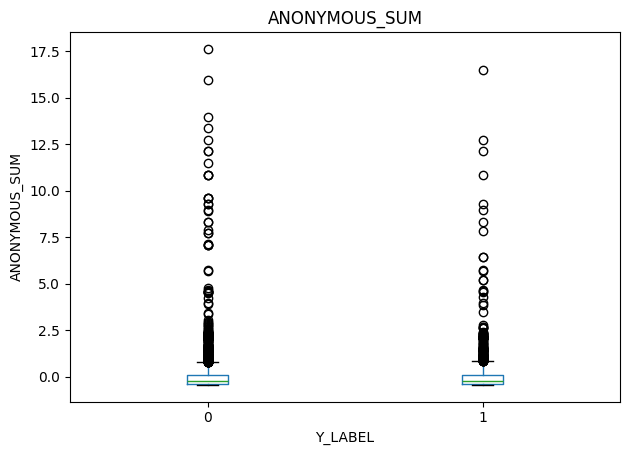

In [19]:
# 변수 리스트 (Y_LABEL, ID, COMPONENT_ARBITRARY, YEAR 제외)
plot_vars = [col for col in comp3_df.columns if col not in ['ID', 'COMPONENT_ARBITRARY', 'YEAR','Y_LABEL']]

plt.figure(figsize=(20, 30))
for i, var in enumerate(plot_vars):
  plt.subplot(6, 3, i+1)
  comp3_df.boxplot(column=var, by='Y_LABEL', grid=False)
  plt.title(var)
  plt.suptitle('')
  plt.xlabel('Y_LABEL')
  plt.ylabel(var)
plt.tight_layout()
plt.show()

산점도를 활용하여 분포를 시각적으로 확인해보았다    
파란색: 정상    
빨간색: 비정상    

C:\Users\KimDongyoung\AppData\Local\Temp\ipykernel_23512\3123593824.py:24: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\KimDongyoung\AppData\Local\Temp\ipykernel_23512\3123593824.py:24: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\KimDongyoung\AppData\Local\Temp\ipykernel_23512\3123593824.py:24: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig.canvas.pri

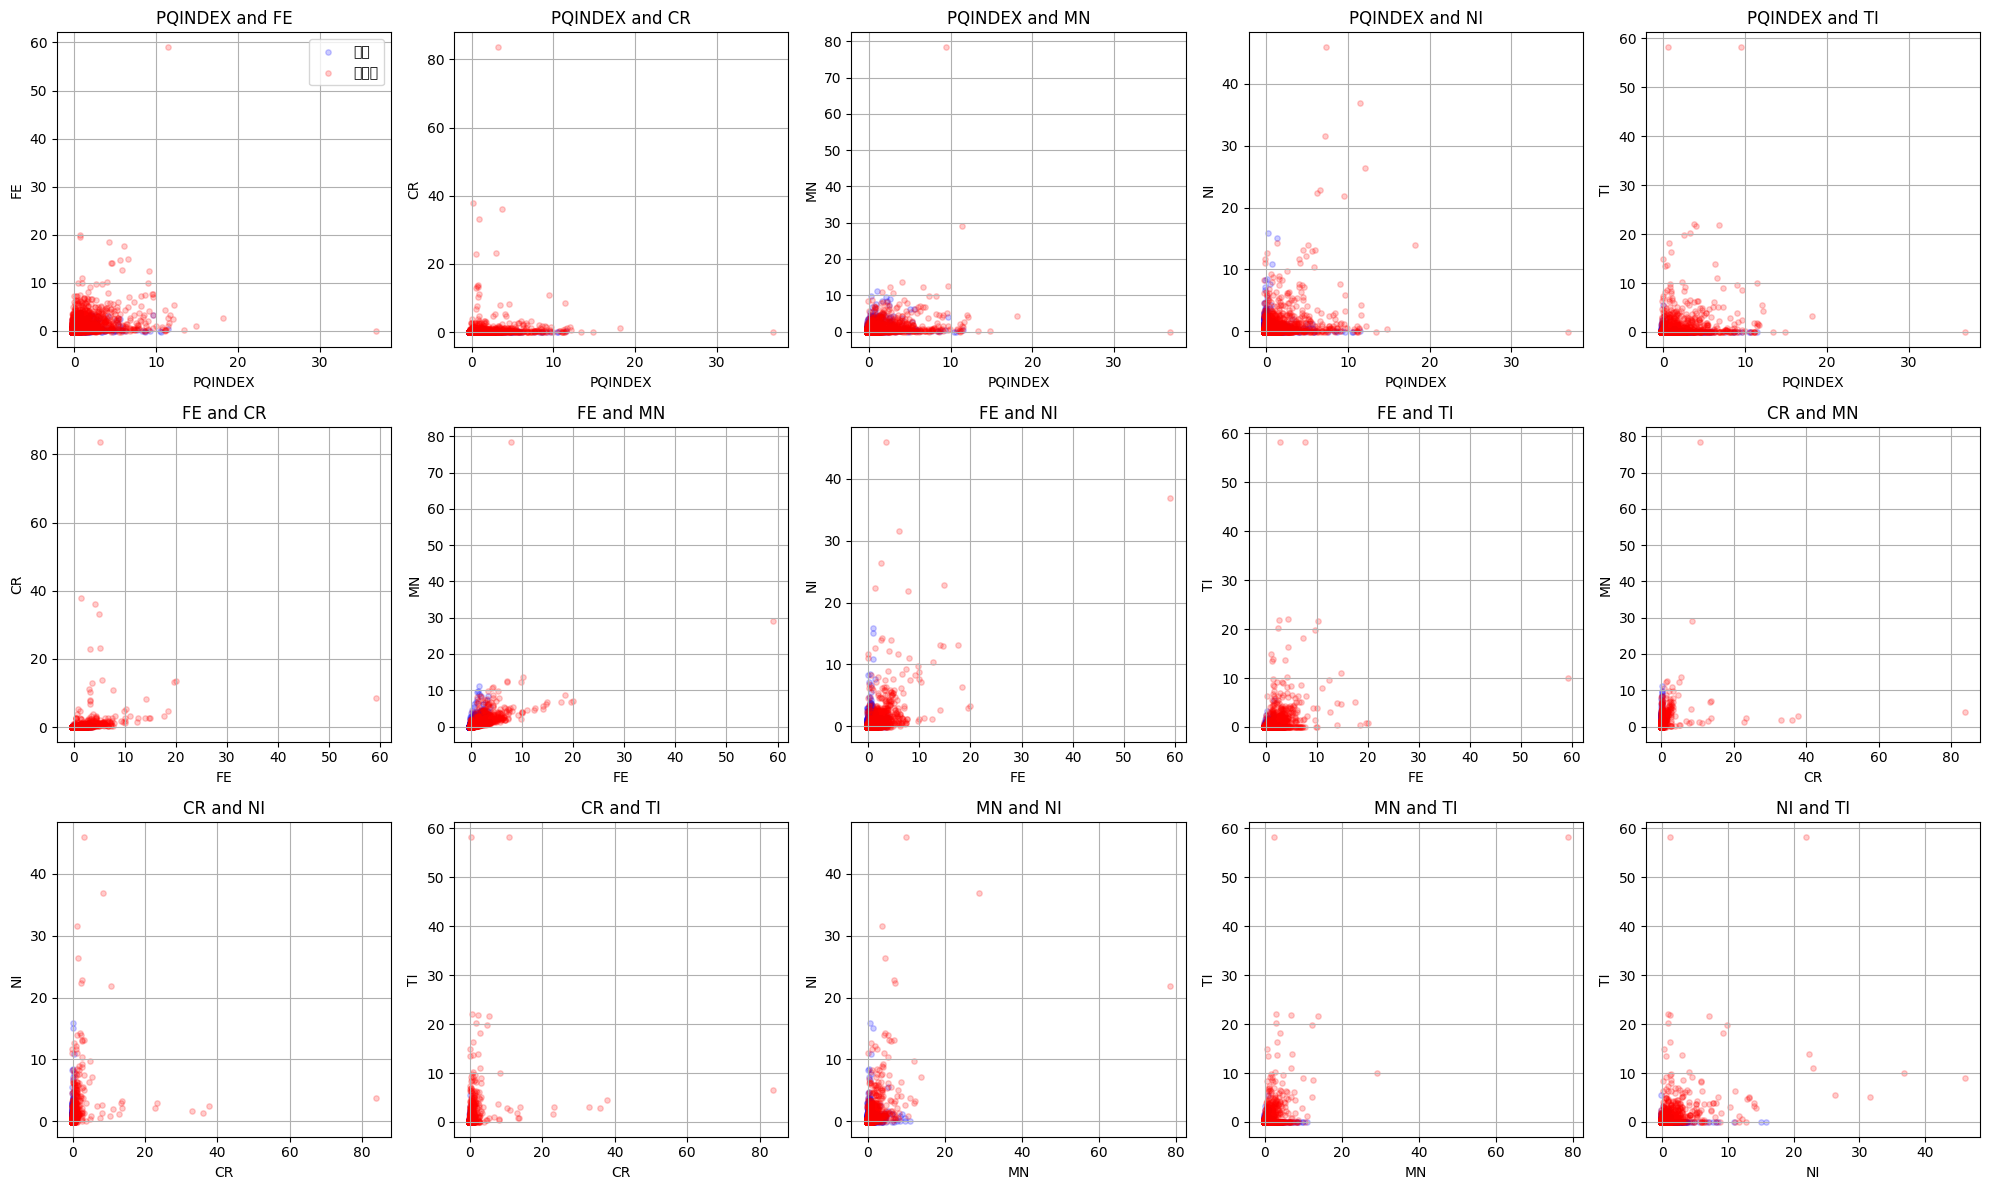

In [20]:
from itertools import combinations

# 산점도에서 색의 투명도를 더 낮추기 위해 alpha 값을 0.2로 조정

# 관련성 높은 변수들 중 2개씩 조합하여 산점도 그리기

important_vars = ['PQINDEX', 'FE', 'CR', 'MN', 'NI', 'TI']
colors = {0: 'blue', 1: 'red'}
labels = {0: '정상', 1: '비정상'}

plt.figure(figsize=(20, 12))
for idx, (x_var, y_var) in enumerate(combinations(important_vars, 2)):
  plt.subplot(3, 5, idx+1)
  for y in [0, 1]:
    subset = comp3_df[comp3_df['Y_LABEL'] == y]
    plt.scatter(subset[x_var], subset[y_var], 
          c=colors[y], label=labels[y] if idx == 0 else "", alpha=0.2, s=15)
  plt.xlabel(x_var)
  plt.ylabel(y_var)
  plt.title(f'{x_var} and {y_var}')
  if idx == 0:
    plt.legend()
  plt.grid(True)
plt.tight_layout()
plt.show()

산점도 결과를 보면 비정상 샘플이 더 넓게 분포하고 있는 것을 볼 수 있다

통계적으로 어떤 변수가 종속 변수와 확인하고자 Mann-Whitney U 검정 과정을 진행했다.   

Mann-Whitney U 검정을 사용한 이유   
t-test 검정은 두 그룹의 평균 차이를 검정하는 방법인데,
정규성(각 그룹의 데이터가 정규분포를 따른다는 가정)과 등분산성(두 그룹의 분산이 비슷하다는 가정)이 필요합니다.

하지만 실제 오일 데이터(특히 원소 농도, PQINDEX 등)는 정규분포를 따르지 않는 경우가 많고
이상치(outlier)가 많거나 분포가 치우쳐 있는 경우가 많습니다.
이럴 때 t-test를 사용하면 결과가 왜곡될 수 있기 때문에
비모수 검정인 Mann-Whitney U test(두 그룹의 분포 차이를 비교, 정규성 가정 불필요)를 사용하는 것이 더 적합하다  

In [21]:
# COMPONENT3 데이터에서 독립변수 리스트 (Y_LABEL, ID, COMPONENT_ARBITRARY 제외)
independent_vars = [col for col in comp3_df.columns if col not in ['ID', 'COMPONENT_ARBITRARY', 'YEAR', 'Y_LABEL']]

# 결과 저장용
test_results = []

for col in independent_vars:
    # 두 그룹 데이터
    group0 = comp3_0[col]
    group1 = comp3_1[col]
    # 정규성, 등분산성 가정이 어려우므로 Mann-Whitney U test 사용
    stat, p = mannwhitneyu(group0, group1, alternative='two-sided')
    # p-value를 소수점 5자리까지만 표시
    p_rounded = round(p, 5)
    test_results.append({'변수': col, 'Mann-Whitney U 통계량': stat, 'p-value': p_rounded})

# 결과 DataFrame으로 정리
test = pd.DataFrame(test_results)
display(test.sort_values('p-value'))

,변수,Mann-Whitney U 통계량,p-value
1,CO,5041572.5,0.00000
2,CR,2238235.5,0.00000
3,CU,4564088.0,0.00000
4,FE,1886591.0,0.00000
5,H2O,4719262.5,0.00000
6,MN,2350153.5,0.00000
7,MO,4630501.5,0.00000
8,NI,3286839.5,0.00000
9,PQINDEX,1545047.0,0.00000
10,TI,3475027.5,0.00000


통계적으로 독립 변수와 종속 변수간의 유의미성을 확인하고자  Mann-Whitney U 검정을 진행했다.   
CR, FE, PQINDEX, MN, TI, NI, H2O, V, CO, CU, MO, V40, AG 등은 오일의 정상/비정상 여부(Y_LABEL)와 강한 관련성이 있는 반면, ANONYMOUS_1, ZN, ANONYMOUS_2는 정상/비정상 여부와 관련성이 약하거나 없었다.   

관련성이 높은 변수들 중에서도 특히 PQINDEX, FE, CR, MN, NI, TI 이 변수들이 Mann-Whitney U 통계량이 가장 낮은 것을 알 수 있다.   
Mann-Whitney U 값이 작을수록 두 그룹의 분포가 더 많이 겹치지 않고, 차이가 크다는 의미이다.    

 

독립 변수들간의 상관계수를 확인해보았다

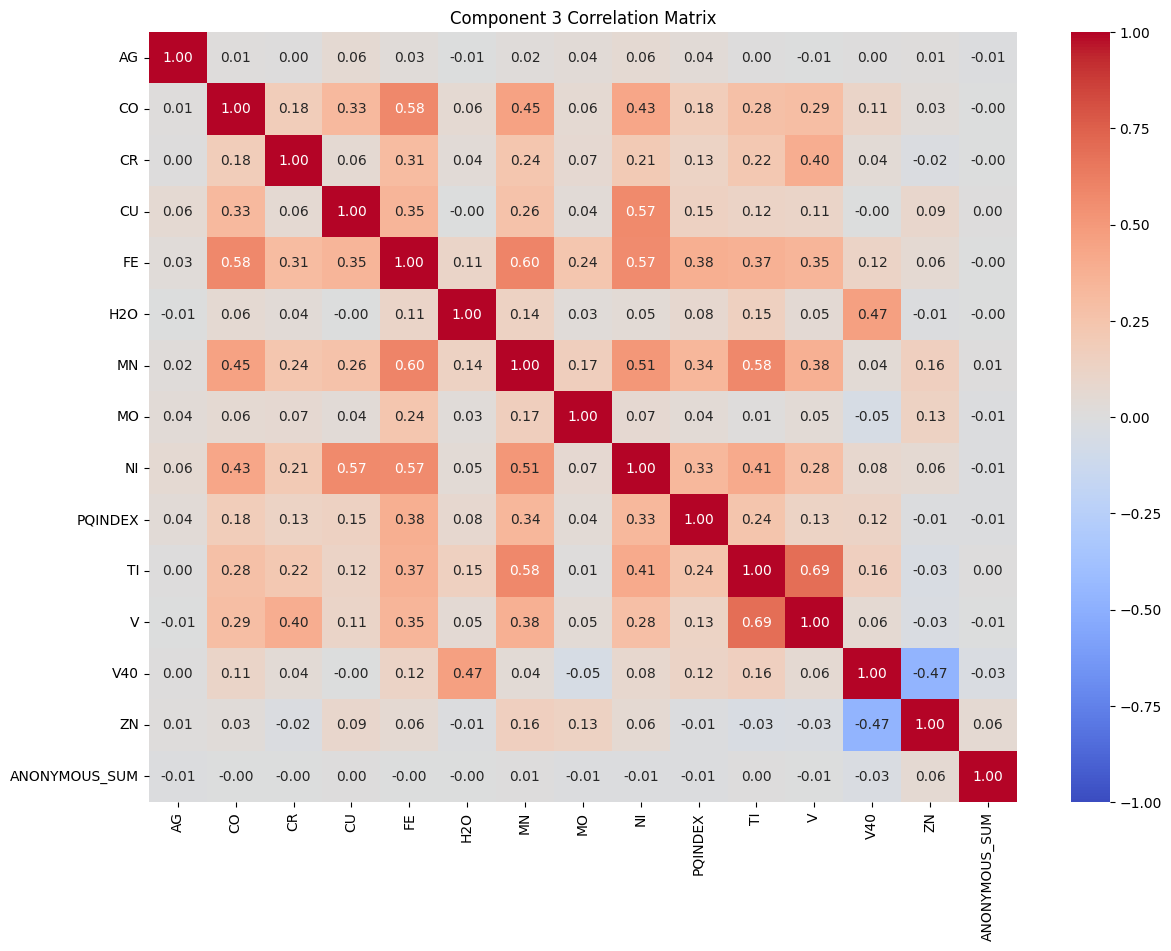

In [22]:
# 변수들간의 상관계수 계산 (수치형 변수만)
corr_matrix = comp3_df[num_cols].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Component 3 Correlation Matrix')
plt.show()

상관계수가 0.7 이상을 넘지 않는 것을 보아 전체적으로 변수들 간의 상관관계가 크지 않다는 것을 볼 수 있었다.    
따라서, 다중공선성 문제는 크지 않을 것으로 판단된다.    

EDA를 통해 알게 된 사실   
MN -> 30 이상은 무조건 1     
CR -> 10 이상은 무조건 1    
CU -> 20 이상은 무조건 1    
FE -> 10 이상은 무조건 1    
H2O -> 10이상은 무조건 1    
NI -> 1이상은 무조건 1    
TI -> 10이상은 무조건 1   
V -> 0이상은 무조건 1   

EDA로 알게 된 사실을 적용해서 변수 파생

In [23]:
# Component 3 데이터에 조건 기반 파생 변수 생성
comp3_df['MN_flag'] = (comp3_df['MN'] >= 30).astype(int)
comp3_df['CR_flag'] = (comp3_df['CR'] >= 10).astype(int)
comp3_df['CU_flag'] = (comp3_df['CU'] >= 20).astype(int)
comp3_df['FE_flag'] = (comp3_df['FE'] >= 10).astype(int)
comp3_df['H2O_flag'] = (comp3_df['H2O'] >= 10).astype(int)
comp3_df['NI_flag'] = (comp3_df['NI'] >= 1).astype(int)
comp3_df['TI_flag'] = (comp3_df['TI'] >= 10).astype(int)
comp3_df['V_flag'] = (comp3_df['V'] >= 0).astype(int)

C:\Users\KimDongyoung\AppData\Local\Temp\ipykernel_23512\3594545709.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp3_df['MN_flag'] = (comp3_df['MN'] >= 30).astype(int)
C:\Users\KimDongyoung\AppData\Local\Temp\ipykernel_23512\3594545709.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp3_df['CR_flag'] = (comp3_df['CR'] >= 10).astype(int)
C:\Users\KimDongyoung\AppData\Local\Temp\ipykernel_23512\3594545709.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

### 모델링 

여러 모델들끼리 성능을 비교하여 가장 성능이 우수한 모델을 발견하고자 한다

In [24]:
# Component 3인 데이터만을 가지고 모델링 진행
comp3_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7050 entries, 0 to 14092
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   7050 non-null   object 
 1   COMPONENT_ARBITRARY  7050 non-null   object 
 2   YEAR                 7050 non-null   int64  
 3   AG                   7050 non-null   float64
 4   CO                   7050 non-null   float64
 5   CR                   7050 non-null   float64
 6   CU                   7050 non-null   float64
 7   FE                   7050 non-null   float64
 8   H2O                  7050 non-null   float64
 9   MN                   7050 non-null   float64
 10  MO                   7050 non-null   float64
 11  NI                   7050 non-null   float64
 12  PQINDEX              7050 non-null   float64
 13  TI                   7050 non-null   float64
 14  V                    7050 non-null   float64
 15  V40                  7050 non-null   float

In [25]:
# COMPONENT_ARBITRARY가 'COMPONENT3'인 데이터만 추출
test_df_3 = test_df[test_df['COMPONENT_ARBITRARY'] == 'COMPONENT3']

In [26]:
# 범주형 변수는 원-핫 인코딩처리리
comp3_df = pd.get_dummies(comp3_df, columns=['YEAR'], prefix='YEAR')

In [27]:
comp3_df

,ID,COMPONENT_ARBITRARY,AG,CO,CR,CU,FE,H2O,MN,MO,...,YEAR_2013,YEAR_2014,YEAR_2015,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,YEAR_2020,YEAR_2021,YEAR_2022
0,TRAIN_00000,COMPONENT3,-0.150214,-0.089633,0.339245,0.336858,1.331290,-0.041588,1.186914,-0.384284,...,False,False,False,False,False,False,False,False,False,False
3,TRAIN_00003,COMPONENT3,-0.150214,-0.089633,-0.115388,-0.260252,-0.264764,-0.041588,-0.160621,-0.400998,...,False,False,False,False,False,False,False,False,False,False
4,TRAIN_00004,COMPONENT3,-0.150214,-0.089633,-0.115388,-0.268007,-0.200996,-0.041588,-0.250456,-0.400998,...,False,False,True,False,False,False,False,False,False,False
5,TRAIN_00005,COMPONENT3,-0.150214,-0.089633,-0.010473,1.120081,0.697370,-0.041588,3.522640,-0.217149,...,False,False,False,False,False,False,False,False,False,False
6,TRAIN_00006,COMPONENT3,-0.150214,-0.089633,-0.115388,-0.244743,-0.268515,-0.041588,-0.250456,-0.400998,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14082,TRAIN_14082,COMPONENT3,-0.150214,-0.089633,-0.045445,-0.252497,-0.116599,-0.041588,-0.070785,-0.367571,...,False,False,False,False,False,False,False,False,False,False
14086,TRAIN_14086,COMPONENT3,-0.150214,3.092669,-0.080416,-0.268007,-0.185992,-0.041588,-0.160621,-0.400998,...,False,False,False,False,False,False,False,False,False,False
14088,TRAIN_14088,COMPONENT3,-0.150214,-0.089633,-0.115388,-0.205969,-0.253511,-0.041588,-0.250456,-0.400998,...,False,False,False,False,False,False,False,False,False,False
14090,TRAIN_14090,COMPONENT3,-0.150214,-0.089633,-0.115388,-0.244743,-0.291021,-0.041588,-0.250456,-0.400998,...,False,True,False,False,False,False,False,False,False,False


In [28]:
# X, y 분리 (ID, COMPONENT_ARBITRARY, Y_LABEL은 제외)
X = comp3_df.drop(columns=['ID', 'COMPONENT_ARBITRARY', 'Y_LABEL'])
y = comp3_df['Y_LABEL']

# train, test 데이터 분할 (예: 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 분할된 데이터 shape 확인
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (5640, 39) (5640,)
Test shape: (1410, 39) (1410,)


In [29]:
# 여러 모델 정의
models = {
  'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
  'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
  'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
  'ExtraTrees': ExtraTreesClassifier(n_estimators=100, random_state=42),
  'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
  'XGBoost': XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss'),
  'LightGBM': LGBMClassifier(n_estimators=100, random_state=42),
  'CatBoost': CatBoostClassifier(iterations=100, random_state=42, verbose=0)
}


results = []

for name, model in models.items():
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

  acc = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

  results.append({
    'Model': name,
    'Accuracy': acc,
    'F1 Score': f1,
    'ROC AUC': auc
  })

results_df = pd.DataFrame(results)
display(results_df.sort_values('F1 Score', ascending=False))

c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:50:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1715, number of negative: 3925
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1878
[LightGBM] [Info] Number of data points in the train set: 5640, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304078 -> initscore=-0.827953
[LightGBM] [Info] Start training from score -0.827953


,Model,Accuracy,F1 Score,ROC AUC
7,CatBoost,0.845390,0.744131,0.916364
2,GradientBoosting,0.846099,0.740120,0.914138
1,RandomForest,0.846809,0.738499,0.920570
6,LightGBM,0.839716,0.730952,0.918907
5,XGBoost,0.830496,0.717828,0.910217
3,ExtraTrees,0.836170,0.713755,0.906485
4,AdaBoost,0.822695,0.685930,0.885863
0,LogisticRegression,0.814894,0.620087,0.862324


Component3 인 데이터에 한해서 하이퍼파라미터 튜닝없이 모델을 돌렸을 때는 CatBoost가 가장 높은 성능을 보였다

In [30]:
# Optuna 스터디 생성 및 최적화 실행
study = optuna.create_study(direction='maximize')
study.optimize(catboost_objective, n_trials=30, show_progress_bar=True)

print("Best parameters:", study.best_params)
print("Best F1 score (CV):", study.best_value)

# 최적 파라미터로 CatBoostClassifier 학습 및 테스트셋 평가
best_cat = CatBoostClassifier(**study.best_params, random_state=42, verbose=0)
best_cat.fit(X_train, y_train)
y_pred_best = best_cat.predict(X_test)
y_proba_best = best_cat.predict_proba(X_test)[:, 1]

acc_best = accuracy_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)
auc_best = roc_auc_score(y_test, y_proba_best)

print(f"Test Accuracy: {acc_best:.4f}")
print(f"Test F1 Score: {f1_best:.4f}")
print(f"Test ROC AUC: {auc_best:.4f}")

[I 2025-06-05 15:53:38,620] A new study created in memory with name: no-name-7e9f00fc-246b-4d4f-9db2-e76ad132fc74


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-06-05 15:53:42,867] Trial 0 finished with value: 0.7317761208263349 and parameters: {'iterations': 350, 'depth': 5, 'learning_rate': 0.17205383187687864}. Best is trial 0 with value: 0.7317761208263349.
[I 2025-06-05 15:53:46,954] Trial 1 finished with value: 0.7303982557492498 and parameters: {'iterations': 350, 'depth': 6, 'learning_rate': 0.021246679448866542}. Best is trial 0 with value: 0.7317761208263349.
[I 2025-06-05 15:53:49,698] Trial 2 finished with value: 0.7291301070285499 and parameters: {'iterations': 300, 'depth': 3, 'learning_rate': 0.06473897397409421}. Best is trial 0 with value: 0.7317761208263349.
[I 2025-06-05 15:53:50,873] Trial 3 finished with value: 0.7315285721456439 and parameters: {'iterations': 300, 'depth': 4, 'learning_rate': 0.1342448003842905}. Best is trial 0 with value: 0.7317761208263349.
[I 2025-06-05 15:53:51,580] Trial 4 finished with value: 0.72816626242765 and parameters: {'iterations': 100, 'depth': 6, 'learning_rate': 0.085810673018399

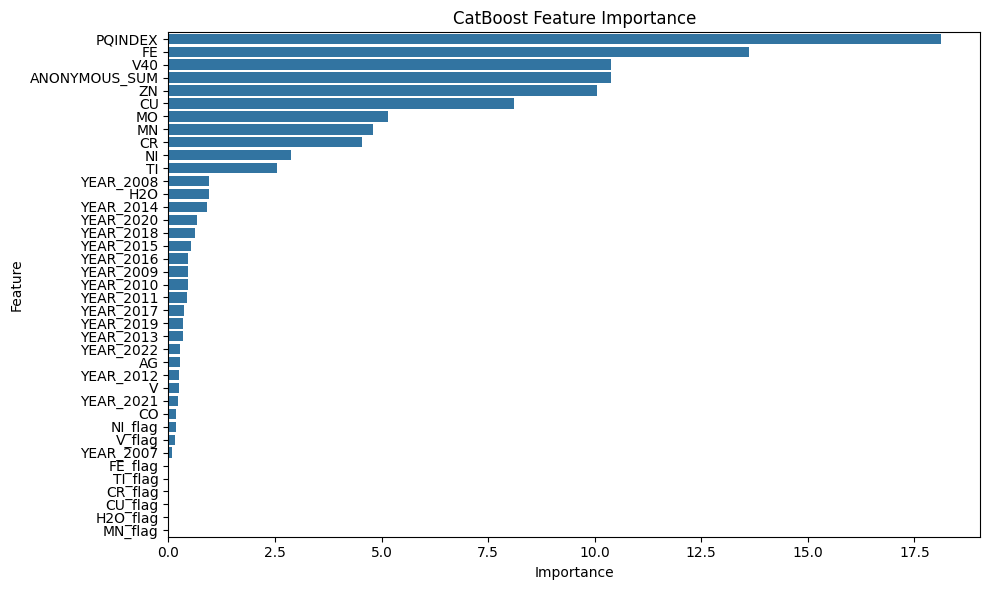

In [31]:
# CatBoost 모델의 feature importance 시각화
importances = best_cat.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('CatBoost Feature Importance')
plt.tight_layout()
plt.show()

Feature importance는 트리 기반 모델에서 각 변수가 예측 시 얼마나 중요한 역할을 했는지를 정량적으로 나타내는 지표이다.   

Optuna 방식을 적용해서 하이퍼파라미터 튜닝을 적용했을 때 test data에 대한 F1 score가 0.7321로 감소하였다.

In [32]:
from sklearn.feature_selection import RFECV

# CatBoostClassifier를 RFECV에 사용
cat_selector = CatBoostClassifier(iterations=100, random_state=42, verbose=0)
rfecv = RFECV(estimator=cat_selector, step=1, cv=5, scoring='f1', n_jobs=-1)

rfecv.fit(X_train, y_train)

print("최적 특성 개수:", rfecv.n_features_)
print("선택된 특성:", list(X_train.columns[rfecv.support_]))

# 선택된 특성으로 모델 평가
X_train_selected = rfecv.transform(X_train)
X_test_selected = rfecv.transform(X_test)

cat_selector.fit(X_train_selected, y_train)
y_pred = cat_selector.predict(X_test_selected)
y_proba = cat_selector.predict_proba(X_test_selected)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

최적 특성 개수: 37
선택된 특성: ['AG', 'CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V', 'V40', 'ZN', 'ANONYMOUS_SUM', 'MN_flag', 'CU_flag', 'FE_flag', 'NI_flag', 'TI_flag', 'V_flag', 'YEAR_2007', 'YEAR_2008', 'YEAR_2009', 'YEAR_2010', 'YEAR_2011', 'YEAR_2012', 'YEAR_2013', 'YEAR_2014', 'YEAR_2015', 'YEAR_2016', 'YEAR_2017', 'YEAR_2018', 'YEAR_2019', 'YEAR_2020', 'YEAR_2021', 'YEAR_2022']
Accuracy: 0.8439716312056738
F1 Score: 0.7387173396674585
ROC AUC: 0.9149386121863186


변수 일부를 제거하고 돌렸을 때 성능은 비슷하거나 오히려 떨어졌다.

## Component 2

In [24]:
train_df_scaled

,ID,COMPONENT_ARBITRARY,YEAR,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN,Y_LABEL,ANONYMOUS_SUM
0,TRAIN_00000,COMPONENT3,2011,-0.150214,-0.089633,0.339245,0.336858,1.331290,-0.041588,1.186914,-0.384284,1.384414,5.293270,0.622282,-0.10655,0.899892,-0.966002,1,-0.418234
1,TRAIN_00001,COMPONENT2,2021,-0.150214,-0.089633,-0.115388,-0.027612,-0.330406,-0.041588,-0.250456,-0.400998,-0.191804,-0.259244,-0.102635,-0.10655,-1.317376,0.119147,0,-0.121986
2,TRAIN_00002,COMPONENT2,2015,-0.150214,-0.089633,-0.080416,-0.252497,-0.326655,-0.041588,-0.250456,-0.400998,-0.191804,-0.260552,-0.102635,-0.10655,-0.740886,-0.332215,0,-0.366290
3,TRAIN_00003,COMPONENT3,2010,-0.150214,-0.089633,-0.115388,-0.260252,-0.264764,-0.041588,-0.160621,-0.400998,-0.191804,-0.242884,-0.102635,-0.10655,0.482642,-1.093888,0,-0.088173
4,TRAIN_00004,COMPONENT3,2015,-0.150214,-0.089633,-0.115388,-0.268007,-0.200996,-0.041588,-0.250456,-0.400998,-0.191804,-0.129674,-0.102635,-0.10655,0.478611,-0.866326,0,-0.280238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14090,TRAIN_14090,COMPONENT3,2014,-0.150214,-0.089633,-0.115388,-0.244743,-0.291021,-0.041588,-0.250456,-0.400998,-0.191804,-0.248773,-0.102635,-0.10655,0.524972,-1.076961,0,-0.410965
14091,TRAIN_14091,COMPONENT1,2013,-0.150214,-0.089633,-0.115388,-0.252497,-0.311651,-0.041588,-0.250456,3.342831,-0.191804,-0.265787,-0.102635,-0.10655,0.164162,1.540935,0,-0.345657
14092,TRAIN_14092,COMPONENT3,2008,-0.150214,-0.089633,0.024499,-0.213724,0.444177,-0.041588,0.378393,-0.233862,0.070899,0.150406,-0.102635,-0.10655,-1.115806,1.339703,0,0.206357
14093,TRAIN_14093,COMPONENT2,2009,-0.150214,-0.089633,-0.115388,1.050289,-0.298523,-0.041588,-0.250456,-0.384284,-0.191804,-0.264479,-0.102635,-0.10655,-1.311328,0.119147,0,0.246056


In [25]:
# COMPONENT3만 추출
comp2_df = train_df_scaled[train_df_scaled['COMPONENT_ARBITRARY'] == 'COMPONENT2']

# Y_LABEL이 0과 1인 데이터 각각 추출
comp2_0 = comp2_df[comp2_df['Y_LABEL'] == 0]
comp2_1 = comp2_df[comp2_df['Y_LABEL'] == 1]

# 주요 변수별 평균 비교
mean_0 = comp2_0.mean(numeric_only=True)
mean_1 = comp2_1.mean(numeric_only=True)
diff = pd.DataFrame({'Y_LABEL=0': mean_0, 'Y_LABEL=1': mean_1})

display(diff)

# 주요 변수별 중앙값 비교
median_0 = comp2_0.median(numeric_only=True)
median_1 = comp2_1.median(numeric_only=True)
median_diff = pd.DataFrame({'Y_LABEL=0': median_0, 'Y_LABEL=1': median_1})

display(median_diff)

,Y_LABEL=0,Y_LABEL=1
YEAR,2013.817755,2013.246883
AG,-0.001380,-0.048676
CO,-0.064706,-0.034081
CR,-0.101363,-0.078149
CU,0.142416,0.310423
FE,-0.309751,-0.246088
H2O,-0.040233,-0.024637
MN,-0.241778,-0.211027
MO,-0.391432,-0.383701
NI,-0.185631,-0.179357


,Y_LABEL=0,Y_LABEL=1
YEAR,2014.000000,2013.000000
AG,-0.150214,-0.150214
CO,-0.089633,-0.089633
CR,-0.115388,-0.115388
CU,-0.182705,-0.105158
FE,-0.324780,-0.307900
H2O,-0.041588,-0.041588
MN,-0.250456,-0.250456
MO,-0.400998,-0.400998
NI,-0.191804,-0.191804


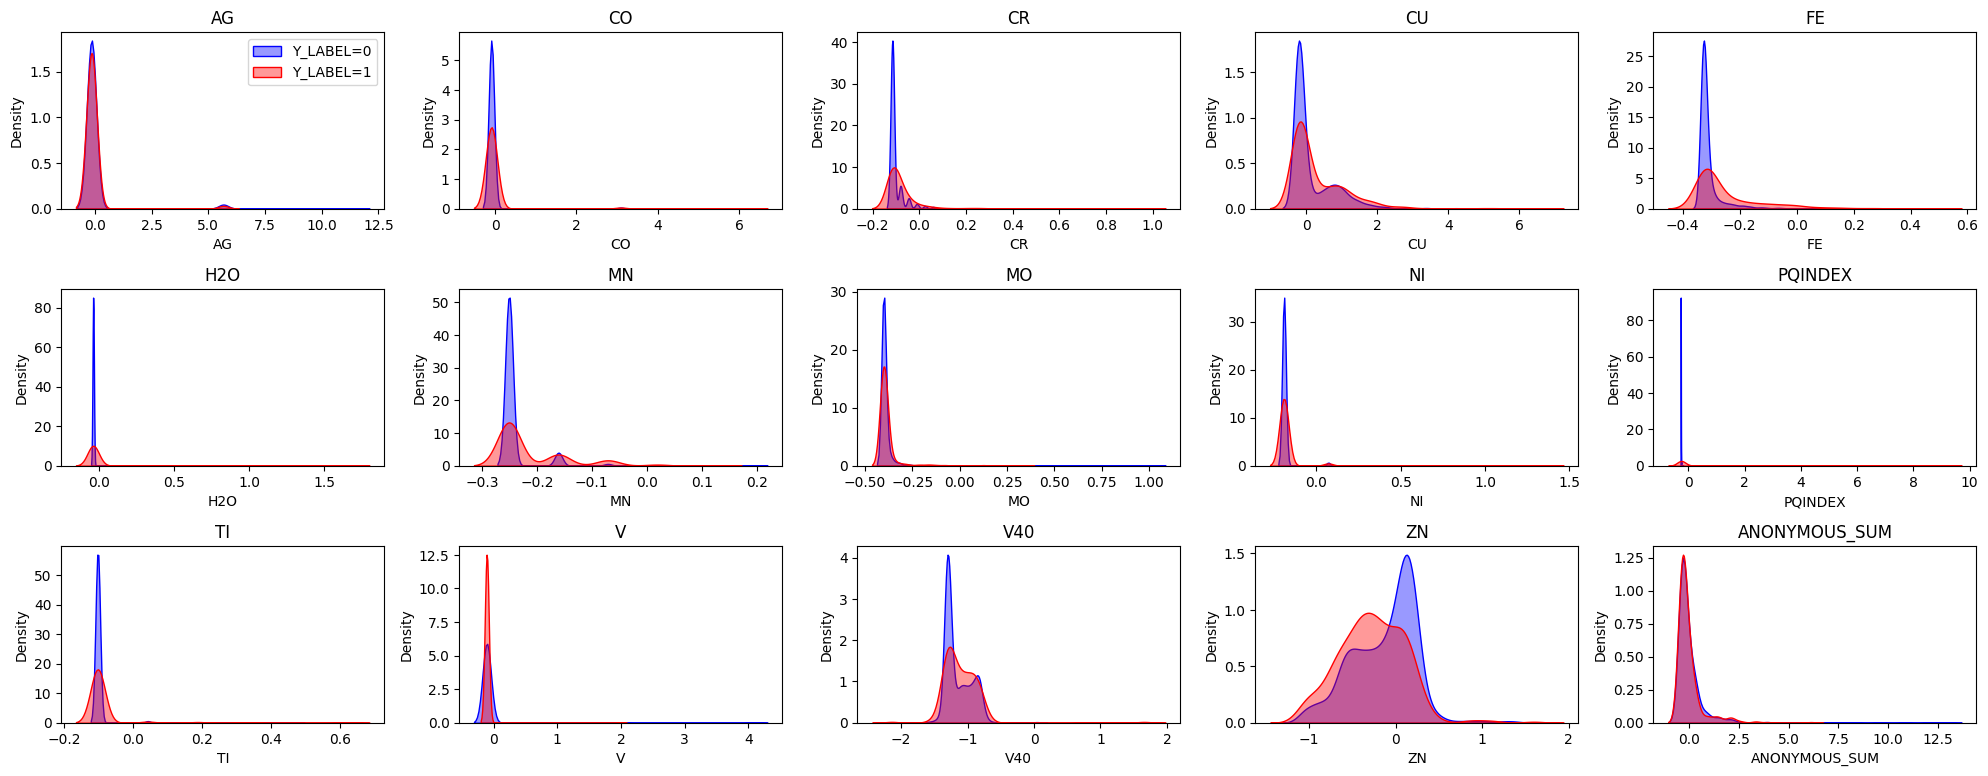

In [26]:
plt.figure(figsize=(20, 10))
for var in num_cols:
  plt.subplot(4, 5, num_cols.index(var)+1)
  sns.kdeplot(comp2_0[var], label='Y_LABEL=0', color='blue', fill=True, alpha=0.4)
  sns.kdeplot(comp2_1[var], label='Y_LABEL=1', color='red', fill=True, alpha=0.4)
  plt.title(var)
  plt.xlabel(var)
  plt.ylabel('Density')
  if num_cols.index(var) == 0:
    plt.legend()
plt.tight_layout()
plt.show()

In [27]:
# 주요 변수별 첨도(kurtosis)와 왜도(skewness) 계산
# independent_vars 정의 (Y_LABEL, ID, COMPONENT_ARBITRARY 제외)
independent_vars = [col for col in comp2_df.columns if col not in ['ID', 'COMPONENT_ARBITRARY', 'Y_LABEL']]

kurt_skew = []
for col in independent_vars:
  kurt_0 = kurtosis(comp2_0[col], nan_policy='omit')
  skew_0 = skew(comp2_0[col], nan_policy='omit')
  kurt_1 = kurtosis(comp2_1[col], nan_policy='omit')
  skew_1 = skew(comp2_1[col], nan_policy='omit')
  kurt_skew.append({
    '변수': col,
    'Y_LABEL=0_첨도': kurt_0,
    'Y_LABEL=0_왜도': skew_0,
    'Y_LABEL=1_첨도': kurt_1,
    'Y_LABEL=1_왜도': skew_1
  })

kurt_skew_df = pd.DataFrame(kurt_skew)
display(kurt_skew_df)

,변수,Y_LABEL=0_첨도,Y_LABEL=0_왜도,Y_LABEL=1_첨도,Y_LABEL=1_왜도
0,YEAR,-0.780477,0.181010,-0.952384,0.298224
1,AG,47.750449,6.700528,52.303481,7.369090
2,CO,223.443885,14.162738,99.309328,9.487829
3,CR,17.891773,3.711812,65.075515,6.958140
4,CU,8.003994,2.280608,12.305964,2.776691
5,FE,25.830215,4.394629,6.193733,2.317071
6,H2O,311.130780,16.971265,100.549253,9.375954
7,MN,33.809103,4.831406,3.646707,1.938360
8,MO,414.812464,17.522213,50.018393,6.418386
9,NI,267.119074,13.319889,216.471954,13.333558


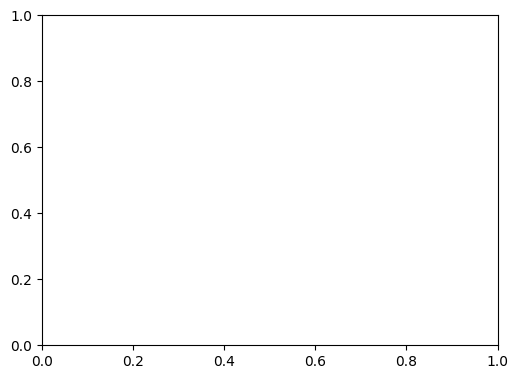

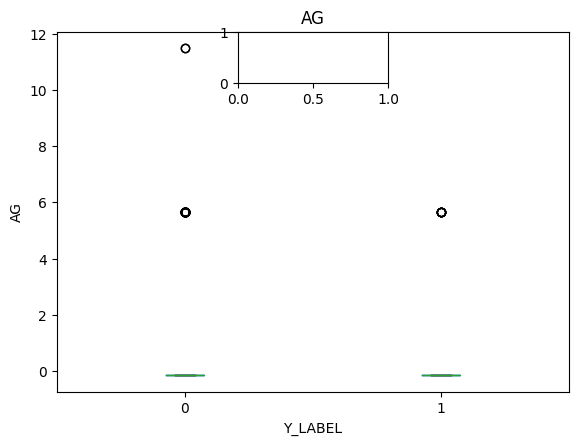

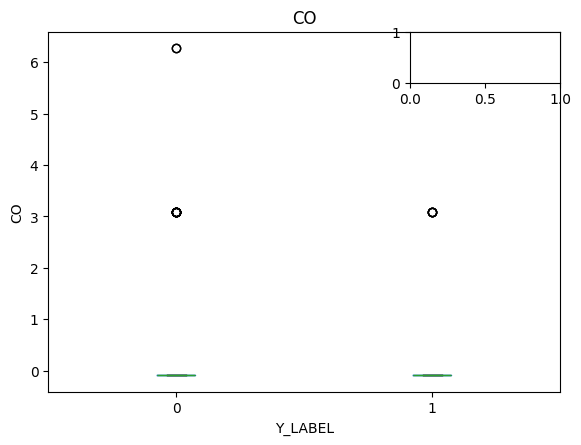

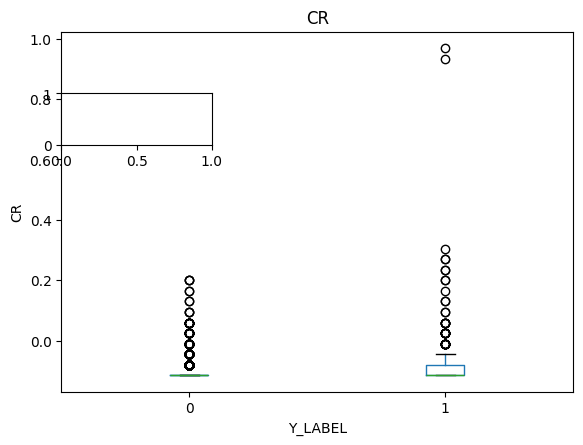

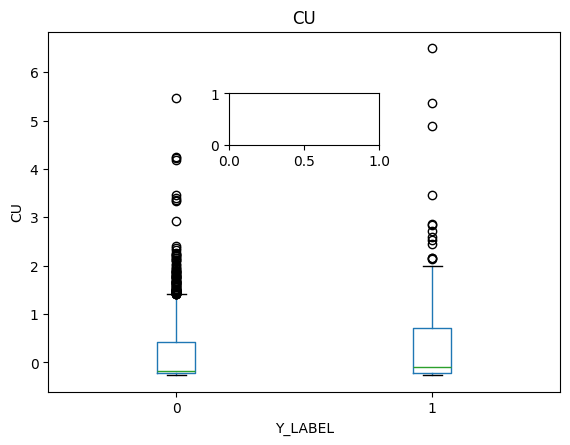

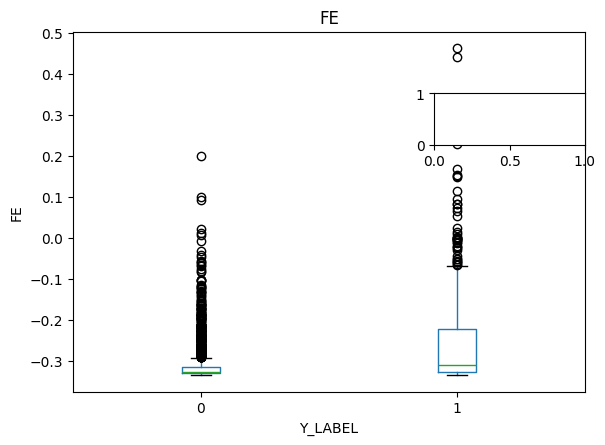

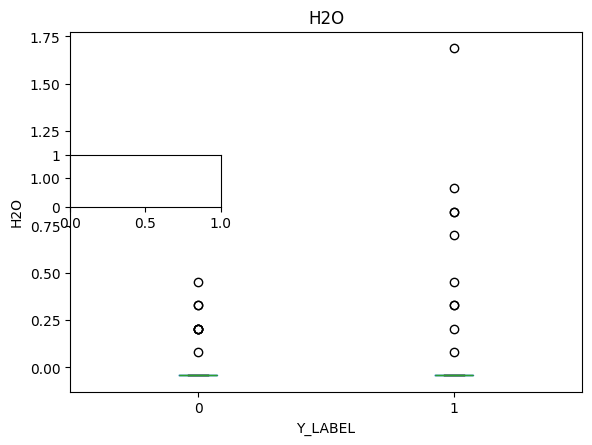

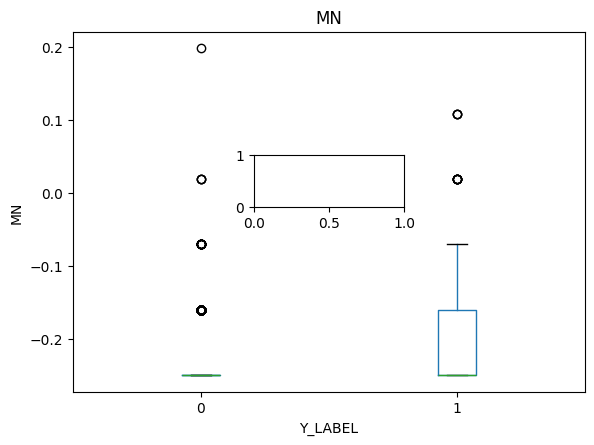

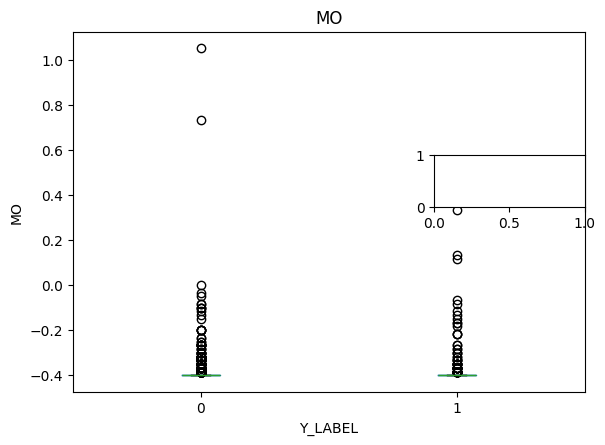

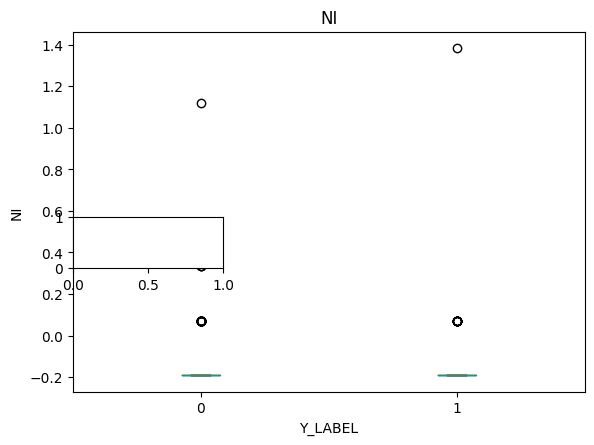

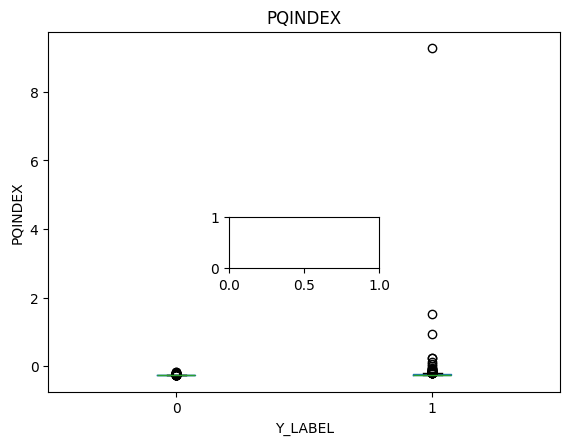

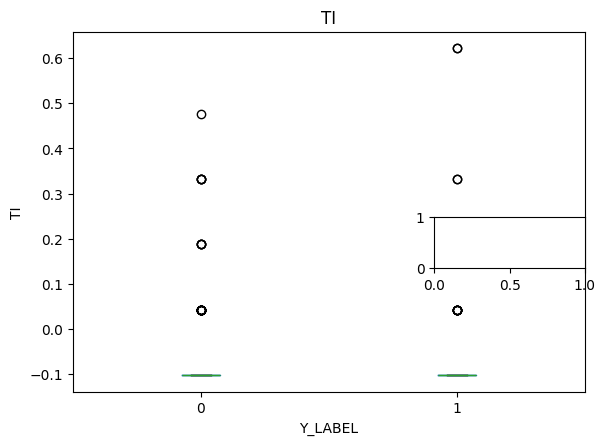

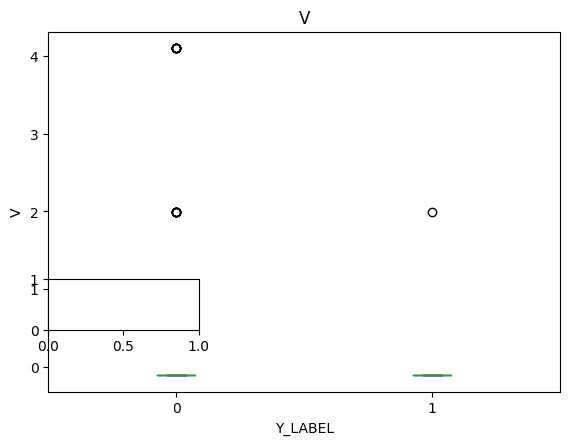

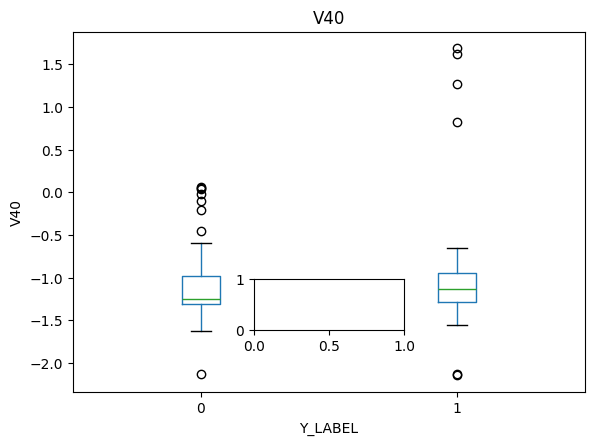

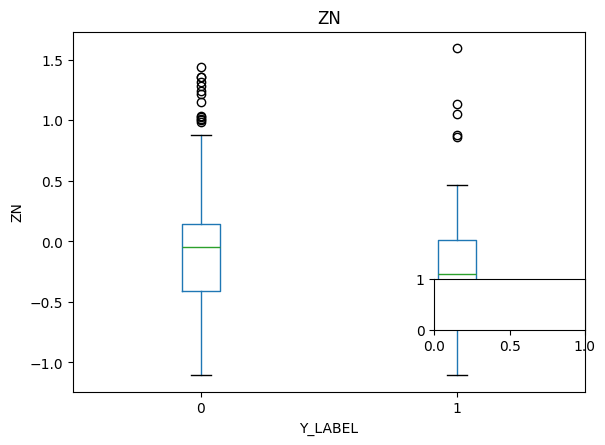

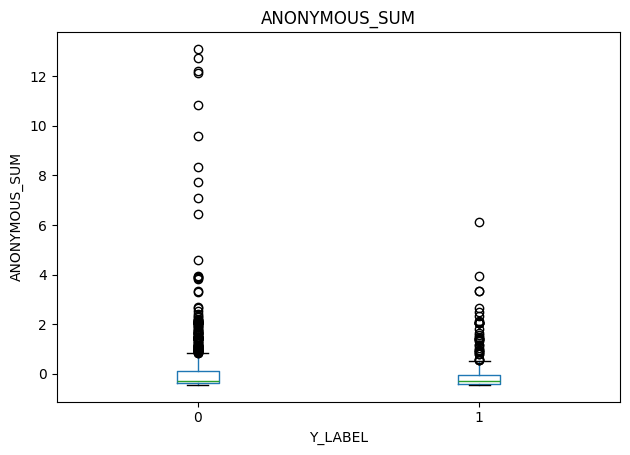

In [28]:
# 변수 리스트 (Y_LABEL, ID, COMPONENT_ARBITRARY, YEAR 제외)
plot_vars = [col for col in comp2_df.columns if col not in ['ID', 'COMPONENT_ARBITRARY', 'YEAR','Y_LABEL']]

plt.figure(figsize=(20, 30))
for i, var in enumerate(plot_vars):
  plt.subplot(6, 3, i+1)
  comp2_df.boxplot(column=var, by='Y_LABEL', grid=False)
  plt.title(var)
  plt.suptitle('')
  plt.xlabel('Y_LABEL')
  plt.ylabel(var)
plt.tight_layout()
plt.show()

In [29]:
# COMPONENT3 데이터에서 독립변수 리스트 (Y_LABEL, ID, COMPONENT_ARBITRARY 제외)
independent_vars = [col for col in comp2_df.columns if col not in ['ID', 'COMPONENT_ARBITRARY', 'YEAR', 'Y_LABEL']]

# 결과 저장용
test_results = []

for col in independent_vars:
    # 두 그룹 데이터
    group0 = comp2_0[col]
    group1 = comp2_1[col]
    # 정규성, 등분산성 가정이 어려우므로 Mann-Whitney U test 사용
    stat, p = mannwhitneyu(group0, group1, alternative='two-sided')
    # p-value를 소수점 5자리까지만 표시
    p_rounded = round(p, 5)
    test_results.append({'변수': col, 'Mann-Whitney U 통계량': stat, 'p-value': p_rounded})

# 결과 DataFrame으로 정리
test = pd.DataFrame(test_results)
display(test.sort_values('p-value'))

,변수,Mann-Whitney U 통계량,p-value
2,CR,309056.5,0.00000
4,FE,220730.0,0.00000
6,MN,300197.0,0.00000
9,PQINDEX,150363.5,0.00000
13,ZN,476722.5,0.00000
3,CU,330667.0,0.00001
5,H2O,376160.5,0.00004
10,TI,373049.0,0.00015
12,V40,338980.5,0.00022
8,NI,378178.5,0.06441


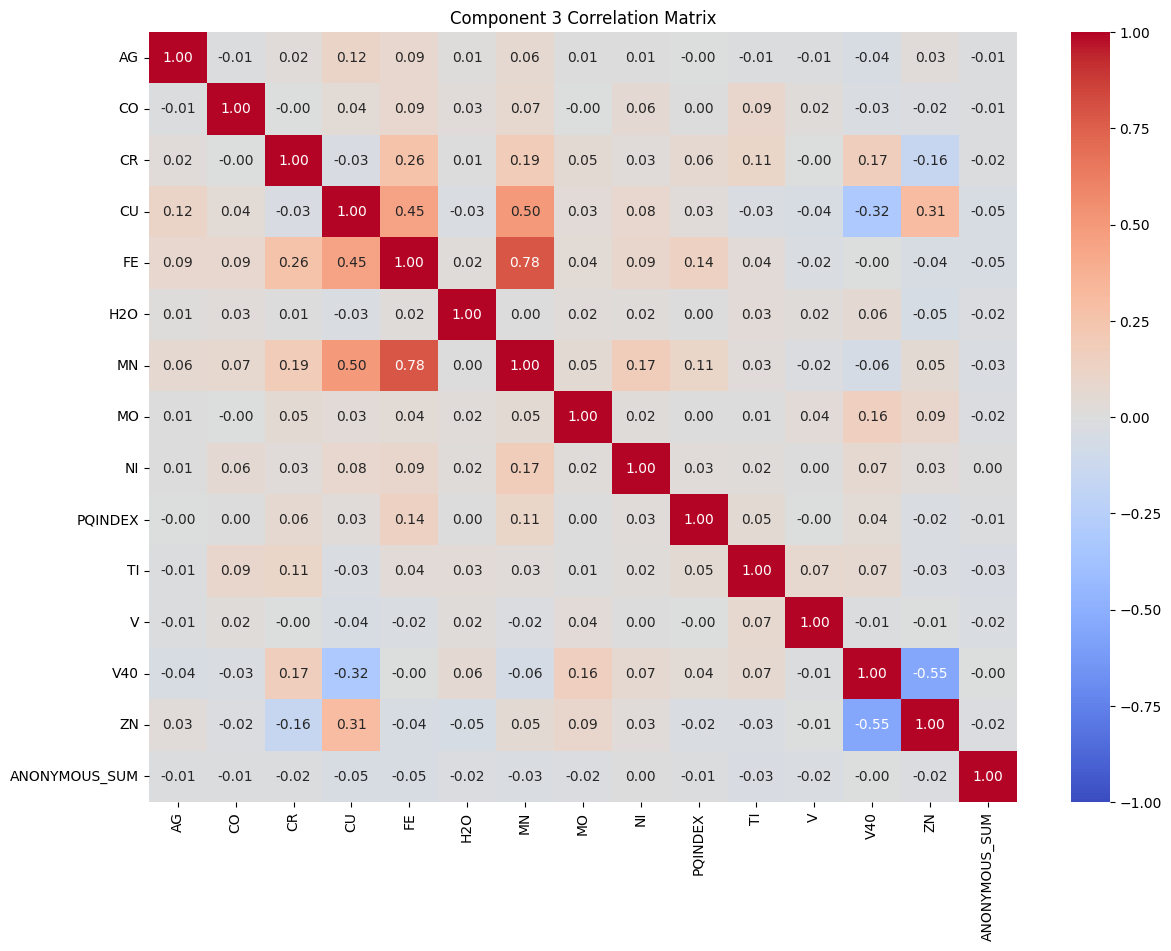

In [30]:
# 변수들간의 상관계수 계산 (수치형 변수만)
corr_matrix = comp2_df[num_cols].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Component 3 Correlation Matrix')
plt.show()

FE와 MN 간의 상관계수가 0.78로 높은 것을 알 수 있다. 따라서 두 변수 중 하나를 제거해 모델링을 해야하기로 판단했다.  

### 모델링

In [35]:
# 범주형 변수는 원-핫 인코딩처리
comp2_df = pd.get_dummies(comp2_df, columns=['YEAR'], prefix='YEAR')

In [36]:
# 제거할 변수 리스트 (CO, AG, ZN, ANONYMOUS_2, YEAR)
# 제거할 변수 리스트 안에 있는 변수들을 제거
remove_vars = ['MN']

In [37]:
X = comp2_df.drop(columns=['ID', 'COMPONENT_ARBITRARY', 'Y_LABEL'] + remove_vars)
y = comp2_df['Y_LABEL']

In [38]:
# train, test 데이터 분할 (예: 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 분할된 데이터 shape 확인
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (1852, 30) (1852,)
Test shape: (464, 30) (464,)


In [41]:
# 여러 모델 정의
models = {
  'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
  'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
  'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
  'ExtraTrees': ExtraTreesClassifier(n_estimators=100, random_state=42),
  'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
  'XGBoost': XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss'),
  'LightGBM': LGBMClassifier(n_estimators=100, random_state=42),
  'CatBoost': CatBoostClassifier(iterations=100, random_state=42, verbose=0)
}

results = []

for name, model in models.items():
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

  acc = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

  results.append({
    'Model': name,
    'Accuracy': acc,
    'F1 Score': f1,
    'ROC AUC': auc
  })

results_df = pd.DataFrame(results)
display(results_df.sort_values('F1 Score', ascending=False))

c:\Users\KimDongyoung\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:34:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 321, number of negative: 1531
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1253
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.173326 -> initscore=-1.562235
[LightGBM] [Info] Start training from score -1.562235


,Model,Accuracy,F1 Score,ROC AUC
4,AdaBoost,0.890086,0.638298,0.822461
5,XGBoost,0.885776,0.629371,0.816569
2,GradientBoosting,0.887931,0.611940,0.834163
7,CatBoost,0.885776,0.601504,0.857227
1,RandomForest,0.883621,0.590909,0.844352
6,LightGBM,0.877155,0.589928,0.805208
3,ExtraTrees,0.872845,0.520325,0.817350
0,LogisticRegression,0.846983,0.219780,0.730273


Component 2의 경우에는 AdaBoost, XGBoost, GradientBoost 순으로 성능이 높았다.   
따라서 AdaBoost를 먼저 하이퍼파라미터 튜닝을 진행하기로 했다.

In [54]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500, step=50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'random_state': 42
    }
    ada = AdaBoostClassifier(**params)
    score = cross_val_score(ada, X_train, y_train, scoring='f1', cv=5, n_jobs=-1)
    return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, show_progress_bar=True)

print("Best parameters:", study.best_params)
print("Best F1 score (CV):", study.best_value)

# 최적 모델로 테스트셋 평가
best_ada = AdaBoostClassifier(**study.best_params, random_state=42)
best_ada.fit(X_train, y_train)
y_pred_best = best_ada.predict(X_test)
y_proba_best = best_ada.predict_proba(X_test)[:, 1]

acc_best = accuracy_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)
auc_best = roc_auc_score(y_test, y_proba_best)

print(f"Test Accuracy: {acc_best:.4f}")
print(f"Test F1 Score: {f1_best:.4f}")
print(f"Test ROC AUC: {auc_best:.4f}")

[I 2025-06-05 12:50:52,819] A new study created in memory with name: no-name-e6b9f23c-a134-4d05-b21a-2cac1c85ac86


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-06-05 12:50:55,769] Trial 0 finished with value: 0.5094366937410416 and parameters: {'n_estimators': 300, 'learning_rate': 0.5568190174922698}. Best is trial 0 with value: 0.5094366937410416.
[I 2025-06-05 12:50:57,529] Trial 1 finished with value: 0.5447295566995123 and parameters: {'n_estimators': 100, 'learning_rate': 0.5612304233405954}. Best is trial 1 with value: 0.5447295566995123.
[I 2025-06-05 12:50:59,465] Trial 2 finished with value: 0.5331083291083291 and parameters: {'n_estimators': 250, 'learning_rate': 0.3800746743469895}. Best is trial 1 with value: 0.5447295566995123.
[I 2025-06-05 12:51:00,901] Trial 3 finished with value: 0.4985646334644424 and parameters: {'n_estimators': 400, 'learning_rate': 0.596909311198511}. Best is trial 1 with value: 0.5447295566995123.
[I 2025-06-05 12:51:01,946] Trial 4 finished with value: 0.5441350216686922 and parameters: {'n_estimators': 300, 'learning_rate': 0.09317148139136183}. Best is trial 1 with value: 0.5447295566995123.


하이퍼파라미터를 적용했을 때 F1 score로 0.6429를 기록했다

In [55]:
# best_params 저장
with open('best_ada_params_comp2.pkl', 'wb') as f:
  pickle.dump(study.best_params, f)

# 나중에 불러와서 바로 사용
with open('best_ada_params_comp2.pkl', 'rb') as f:
  loaded_params = pickle.load(f)

# 모델에 적용
# rf = RandomForestClassifier(**loaded_params, random_state=42, n_jobs=-1)
# rf.fit(X_train, y_train)

하이퍼파라미터 튜닝을 진행했을 때 하지 않았을 때보다 성능이 더 오르지는 않았다.   
추가적으로 최적의 변수 조합을 구하는 방법인 RFECV를 적용해서 성능을 올리기 위한 시도를 해보기로 했다.

In [56]:
# 사용할 분류기 선택 (AdaBoost)
selector_model = AdaBoostClassifier(n_estimators=100, random_state=42)

# RFECV 객체 생성 (교차검증은 5폴드, F1 score 기준)
rfecv = RFECV(estimator=selector_model, step=1, cv=5, scoring='f1', n_jobs=-1)

# 피처 선택 수행
rfecv.fit(X_train, y_train)

print("최적 특성 개수:", rfecv.n_features_)
print("선택된 특성:", list(X_train.columns[rfecv.support_]))

# 선택된 특성만 사용해 데이터 변환
X_train_selected = rfecv.transform(X_train)
X_test_selected = rfecv.transform(X_test)

# 선택된 특성으로 모델 학습 및 평가 예시
selector_model.fit(X_train_selected, y_train)
y_pred = selector_model.predict(X_test_selected)
y_proba = selector_model.predict_proba(X_test_selected)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

최적 특성 개수: 17
선택된 특성: ['CR', 'CU', 'FE', 'H2O', 'MO', 'PQINDEX', 'V', 'V40', 'ZN', 'ANONYMOUS_SUM', 'YEAR_2007', 'YEAR_2008', 'YEAR_2012', 'YEAR_2016', 'YEAR_2019', 'YEAR_2021', 'YEAR_2022']
Accuracy: 0.8879310344827587
F1 Score: 0.6285714285714286
ROC AUC: 0.8235677083333333


RFECV를 적용했을 때 F1 score로 0.6285714285714286 기록했다

이번에는 best_param이 적용된 모델에 대해 RFECV방법을 적용해보기로 했다.

In [57]:
# best_param을 적용한 AdaBoostClassifier 생성
best_ada = AdaBoostClassifier(**study.best_params, random_state=42)

# RFECV 객체 생성 (교차검증은 5폴드, F1 score 기준)
rfecv = RFECV(estimator=best_ada, step=1, cv=5, scoring='f1', n_jobs=-1)

# 피처 선택 수행
rfecv.fit(X_train, y_train)

print("최적 특성 개수:", rfecv.n_features_)
print("선택된 특성:", list(X_train.columns[rfecv.support_]))

# 선택된 특성만 사용해 데이터 변환
X_train_selected = rfecv.transform(X_train)
X_test_selected = rfecv.transform(X_test)

# 선택된 특성으로 모델 학습 및 평가
best_ada.fit(X_train_selected, y_train)
y_pred = best_ada.predict(X_test_selected)
y_proba = best_ada.predict_proba(X_test_selected)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

최적 특성 개수: 12
선택된 특성: ['CU', 'FE', 'MO', 'PQINDEX', 'V', 'V40', 'ZN', 'ANONYMOUS_SUM', 'YEAR_2007', 'YEAR_2008', 'YEAR_2012', 'YEAR_2022']
Accuracy: 0.8857758620689655
F1 Score: 0.624113475177305
ROC AUC: 0.8252115885416667


F1 score로 0.624113475177305가 나왔다.    
따라서 Component 2에서는 하이퍼파라미터만 적용했을 때 성능이 가장 높았다.   

In [62]:
# 최적 모델로 테스트셋 평가
best_ada = AdaBoostClassifier(**loaded_params, random_state=42)
best_ada.fit(X_train, y_train)
y_pred_best = best_ada.predict(X_test)
y_proba_best = best_ada.predict_proba(X_test)[:, 1]

acc_best = accuracy_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)
auc_best = roc_auc_score(y_test, y_proba_best)

print(f"Test Accuracy: {acc_best:.4f}")
print(f"Test F1 Score: {f1_best:.4f}")
print(f"Test ROC AUC: {auc_best:.4f}")

Test Accuracy: 0.8922
Test F1 Score: 0.6429
Test ROC AUC: 0.8334


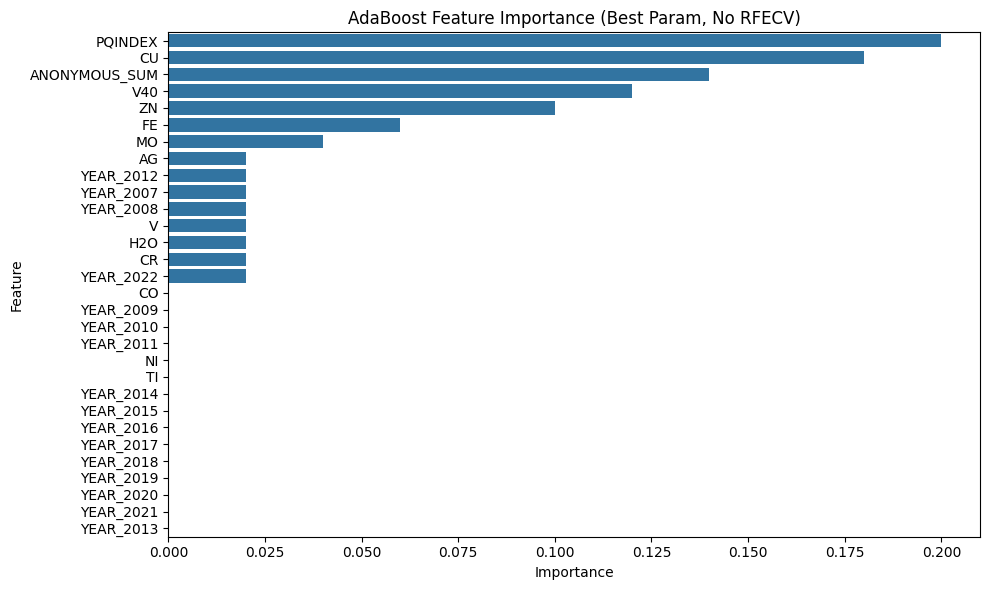

In [63]:
# RFECV를 사용하지 않은 best_ada의 feature importance 시각화
importances = best_ada.feature_importances_
feature_names = X_train.columns  # 전체 feature 사용

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('AdaBoost Feature Importance (Best Param, No RFECV)')
plt.tight_layout()
plt.show()